# Baseline Models

We make some baseline models. Our method of evaluating our model's performance in this notebook will be on how well it performs against data observed from 2025-01-01 to 2025-12-31. We will consider both RMSE and RSS.
In the process of making these models, it become clear very quickly that the Seasonal Naive Forecast was performing far worse than the Seasonal Average Forecast and so we focused on the latter.

In [168]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Patch
import datetime
import random

## Baseline for Daily Citywide Rat Sightings Data

In [169]:
rs = pd.read_csv('../scr/data/cleaned_rat_sightings_data/cleaned_rat_sightings.csv')

In the following code block, we choose the date of our cut off. We will model/train on data after 2020-01-01 to right before the cut_off date and then forecast the dates after the cut_off up until 2025-12-31.

In [170]:
cut_off = '2025-09-01'

In [171]:

rs['created_date'] = pd.to_datetime(rs['created_date']) 
rs['closed_date'] = pd.to_datetime(rs['closed_date'])
rs['resolution_action_updated_date'] = pd.to_datetime(rs['resolution_action_updated_date'])


# Start by cutting off datas before 2020-01-01 and after 2025-12-31.

rs = rs[rs['created_date']<='2025-12-31']
rs = rs[rs['created_date']>='2020-01-01']


day_before_obj = datetime.datetime.strptime(cut_off, '%Y-%m-%d') - datetime.timedelta(days=1)
# Convert back to string (date only)
before_cut_off = day_before_obj.strftime('%Y-%m-%d')

rs_train = rs[rs['created_date']<cut_off]
rs_test = rs[rs['created_date']>=cut_off]


Our EDA indicates that the number of rat sightings has seasonality, but no trend. We consider a baseline model of a seasonal average forecast i.e. we simply forecast the average of all observations in the past seaons. We assume here that each season is 1 year or 365 days long.

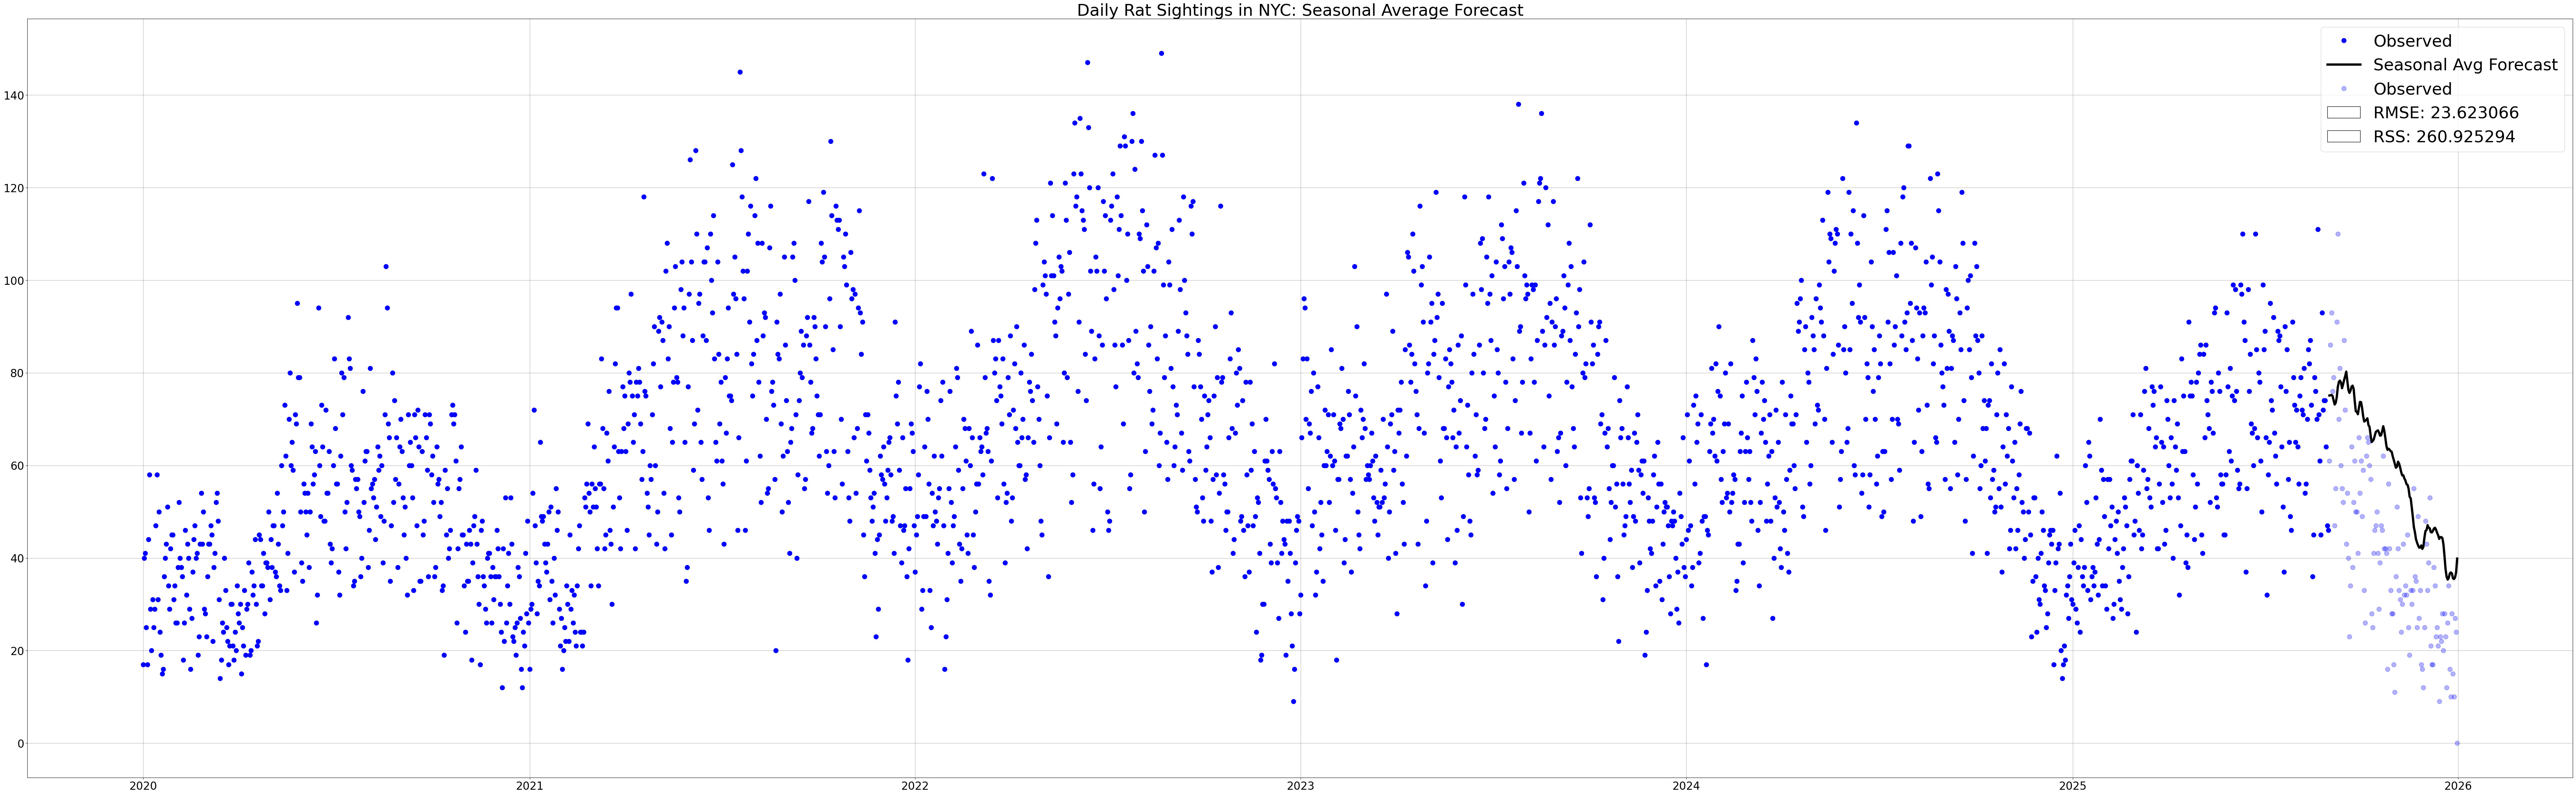

In [172]:
nrs_test = rs_test.groupby([rs_test['created_date'].dt.date]).size().reset_index(name='count')

nrs_train = rs_train.groupby([rs_train['created_date'].dt.date]).size().reset_index(name='count')

full_range = pd.date_range(start="2020-01-01", end=before_cut_off, freq='D')

# reindex and fill missing dates with 0
nrs_train = nrs_train.set_index('created_date').reindex(full_range, fill_value=0).rename_axis('created_date').reset_index()

full_range = pd.date_range(start=cut_off, end="2025-12-31",freq='D')

# reindex and fill missing dates with 0
nrs_test = nrs_test.set_index('created_date').reindex(full_range, fill_value=0).rename_axis('created_date').reset_index()

def seasonal_average_forecast(data, target_dates, years_back=5, day_window=5):
    df = data.copy()
    # ensure datetime type
    df["created_date"] = pd.to_datetime(df["created_date"])
    df["doy"] = df["created_date"].dt.dayofyear
    df["year"] = df["created_date"].dt.year

    forecasts = []
    for target_date in target_dates:
        target_doy = target_date.dayofyear
        target_year = target_date.year
        mask = ((df["year"] >= target_year - years_back) & (df["year"] < target_year) & (np.abs(df["doy"] - target_doy) <= day_window))
        forecasts.append(df.loc[mask, "count"].mean())
    return pd.Series(forecasts, index=target_dates)


# define future dates
# number of years to forecast
years_to_forecast = 1

last_date = nrs_train["created_date"].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(nrs_test), freq="D")

fig = plt.figure(figsize=(100,30))

# compute seasonal-average forecast
forecast = seasonal_average_forecast(nrs_train, future_dates, years_back=5)


    # plot observed data
plt.plot(nrs_train["created_date"], nrs_train["count"], "o", color="b", markersize=10, label="Observed")

# plot forecast
plt.plot(forecast.index, forecast.values, color="black", linewidth=5, linestyle = "-", label="Seasonal Avg Forecast")

plt.plot(nrs_test["created_date"], nrs_test["count"], "o",color="b", markersize=10, alpha=0.3, label="Observed")

plt.grid(True)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)


rmse = np.sqrt(np.mean((nrs_test['count'] - forecast.values)**2))
rss = np.sqrt(np.sum((nrs_test['count'] - forecast.values)**2))

text_box = Patch(facecolor='white', edgecolor='black', label=f'RMSE: {rmse}')
text_box2 = Patch(facecolor='white', edgecolor='black', label=f'RSS: {rss}')


handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([text_box, text_box2])
labels.extend([f"RMSE: {rmse:.6f}", f"RSS: {rss:.6f}"])

plt.legend(handles=handles, labels=labels, fontsize=36)

plt.title("Daily Rat Sightings in NYC: Seasonal Average Forecast", fontsize=36)
plt.show()

## Baseline for Weekly Citywide Rat Sightings

## Baseline for Monthly Citywide Rat Sightings

## Baseline for Daily Borough Rat Sightings

In [173]:
daily_borough_rs = pd.read_csv("../scr/data/cleaned_rat_sightings_data/daily_borough_rs.csv")

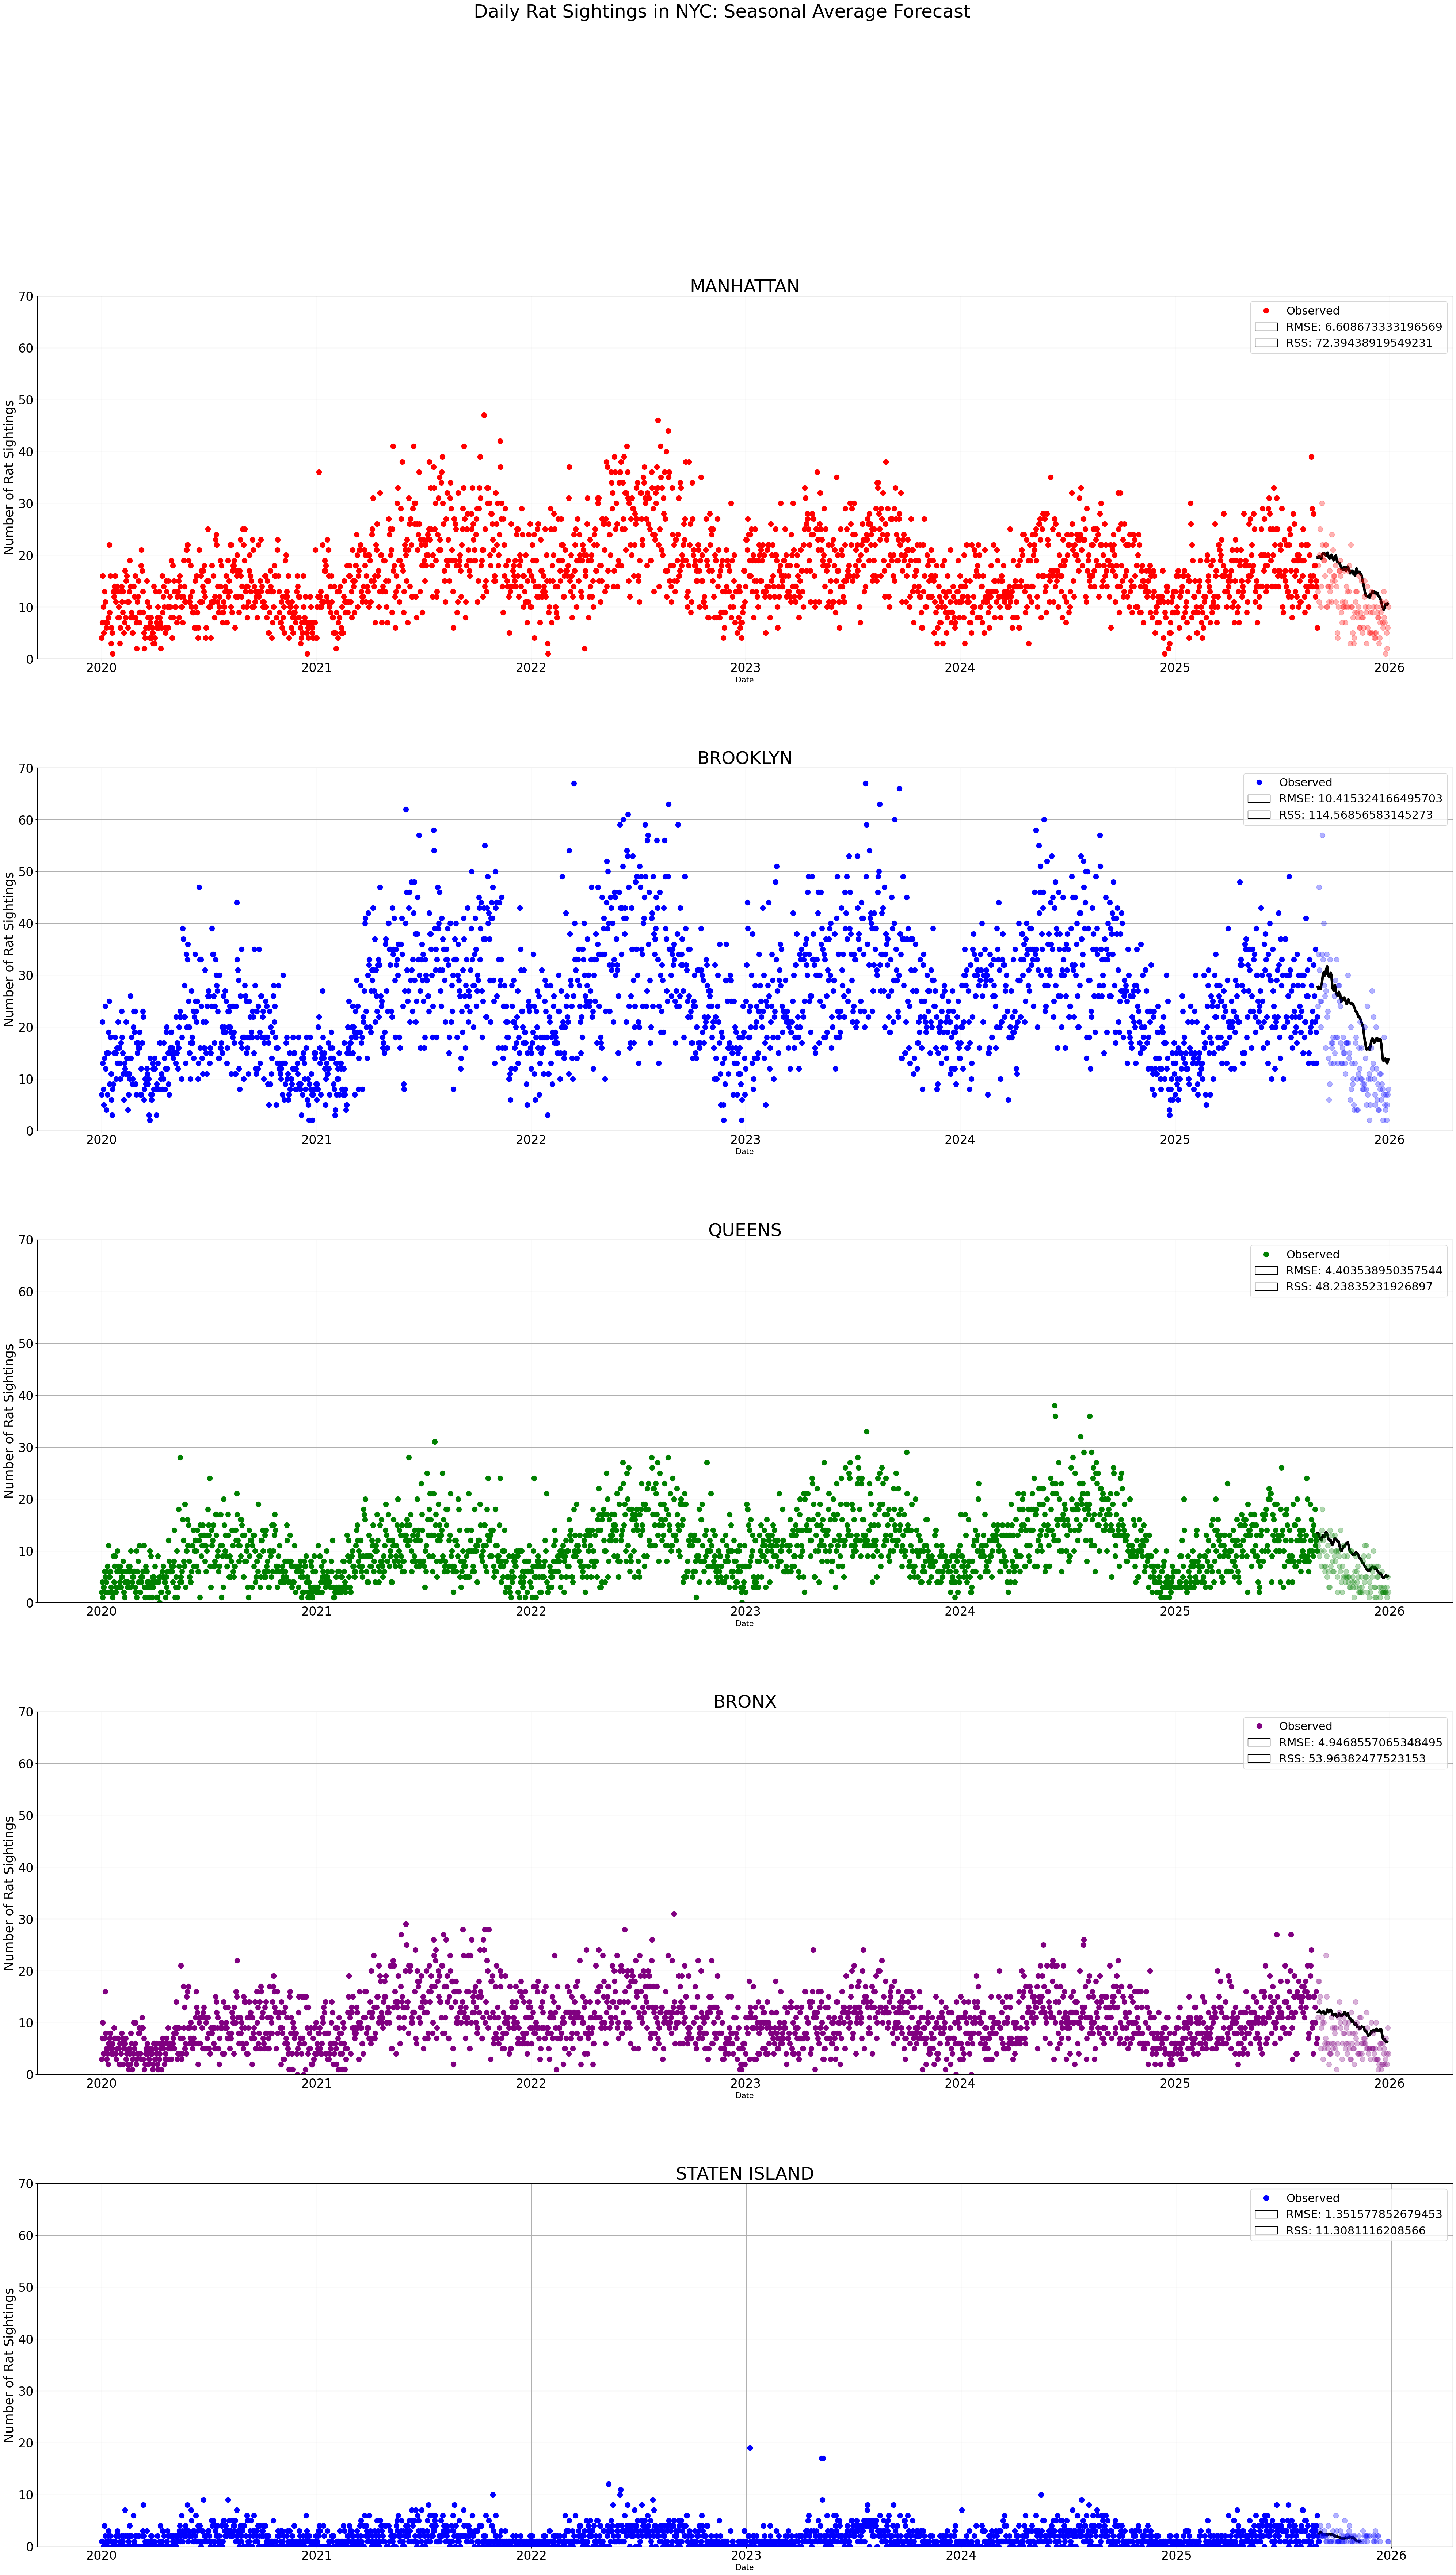

In [174]:
cdate_borough_test = daily_borough_rs[daily_borough_rs['created_date']>=cut_off]
cdate_borough_test = cdate_borough_test[cdate_borough_test['created_date']<='2025-12-31']

cdate_borough = daily_borough_rs[daily_borough_rs['created_date']<cut_off]
cdate_borough = cdate_borough[cdate_borough['created_date']>='2020-01-01']


boroughs = [b for b in rs['borough'].unique() if pd.notnull(b) and b != 'Unspecified']


def seasonal_average_forecast(data, target_dates, years_back=5, day_window=5):
    df = data.copy()
    df["created_date"] = pd.to_datetime(df["created_date"])
    df["doy"] = df["created_date"].dt.dayofyear
    df["year"] = df["created_date"].dt.year

    forecasts = []
    for target_date in target_dates:
        target_doy = target_date.dayofyear
        target_year = target_date.year
        mask = (
            (df["year"] >= target_year - years_back) &
            (df["year"] < target_year) &
            (np.abs(df["doy"] - target_doy) <= day_window)
        )

        forecasts.append(df.loc[mask, "count"].mean())

    return pd.Series(forecasts, index=target_dates)


# ensure global dataframe is datetime
cdate_borough["created_date"] = pd.to_datetime(cdate_borough["created_date"])


fig = plt.figure(figsize=(50,80))
gs = gridspec.GridSpec(5,1, figure=fig, wspace=0.3, hspace=0.3)

colors = ["r", "b", "g", "purple", "b"]

for i, borough in enumerate(boroughs):
    ax = fig.add_subplot(gs[i])

    borough_data = cdate_borough[cdate_borough["borough"] == borough].assign(created_date=lambda df: pd.to_datetime(df["created_date"])).sort_values("created_date").set_index("created_date")

    # create a complete daily date range
    full_range = pd.date_range(start="2020-01-01", end=before_cut_off, freq="D")

    # reindex and fill missing days with 0
    borough_data = borough_data.reindex(full_range).assign(count=lambda df: df["count"].fillna(0),borough=borough).rename_axis("created_date").reset_index()

    borough_data_test = cdate_borough_test[cdate_borough_test["borough"] == borough].sort_values("created_date").copy()
        
    last_date = cdate_borough["created_date"].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(borough_data_test), freq="D")
    
    # compute seasonal-average forecast
    forecast = seasonal_average_forecast(borough_data,future_dates,years_back=5)

    # plot observed data
    ax.plot(borough_data["created_date"].dt.to_pydatetime(), borough_data["count"], "o", color=colors[i], markersize=10, label="Observed")

    # plot forecast
    ax.plot(forecast.index, forecast.values, color="black", linewidth=5, linestyle = "-", label="Seasonal Avg Forecast")

    borough_data_test["created_date"] = pd.to_datetime(borough_data_test["created_date"])
    ax.plot(borough_data_test["created_date"], borough_data_test["count"], "o", color=colors[i], markersize=10, alpha=0.3, label="Observed")

    actual_series = borough_data_test.set_index('created_date')['count']
    actual_aligned = actual_series.reindex(forecast.index, fill_value=0)

    rmse = np.sqrt(np.mean((actual_aligned - forecast.values)**2))
    rss = np.sqrt(np.sum((actual_aligned - forecast.values)**2))

    ax.set_title(f"{borough}", fontsize=35)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Number of Rat Sightings", fontsize=25)
    ax.grid(True)
    ax.set_ylim(0,70)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    text_box = Patch(facecolor='white', edgecolor='black', label=f'RMSE: {rmse}')
    text_box2 = Patch(facecolor='white', edgecolor='black', label=f'RSS: {rss}')
    ax.legend(handles=[ax.lines[0], text_box, text_box2], fontsize=22)
    
    

plt.suptitle("Daily Rat Sightings in NYC: Seasonal Average Forecast", fontsize=36)
plt.show()





## Baseline for Weekly Borough Rat Sightings

In [175]:
weekly_borough_rs = pd.read_csv("../scr/data/cleaned_rat_sightings_data/weekly_borough_rs.csv")

# Convert weekly range to start-of-week datetime
weekly_borough_rs["week_start"] = pd.to_datetime(weekly_borough_rs["created_date"].str.split("/").str[0])

In [176]:
# Split train/test
train = weekly_borough_rs[(weekly_borough_rs["week_start"] >= "2020-01-01") & (weekly_borough_rs["week_start"] < cut_off)]
test = weekly_borough_rs[(weekly_borough_rs["week_start"] >= cut_off) & (weekly_borough_rs["week_start"] <= "2025-12-31")]


In [177]:
# Boroughs
boroughs = [b for b in weekly_borough_rs["borough"].unique() if pd.notnull(b) and b != "Unspecified"]

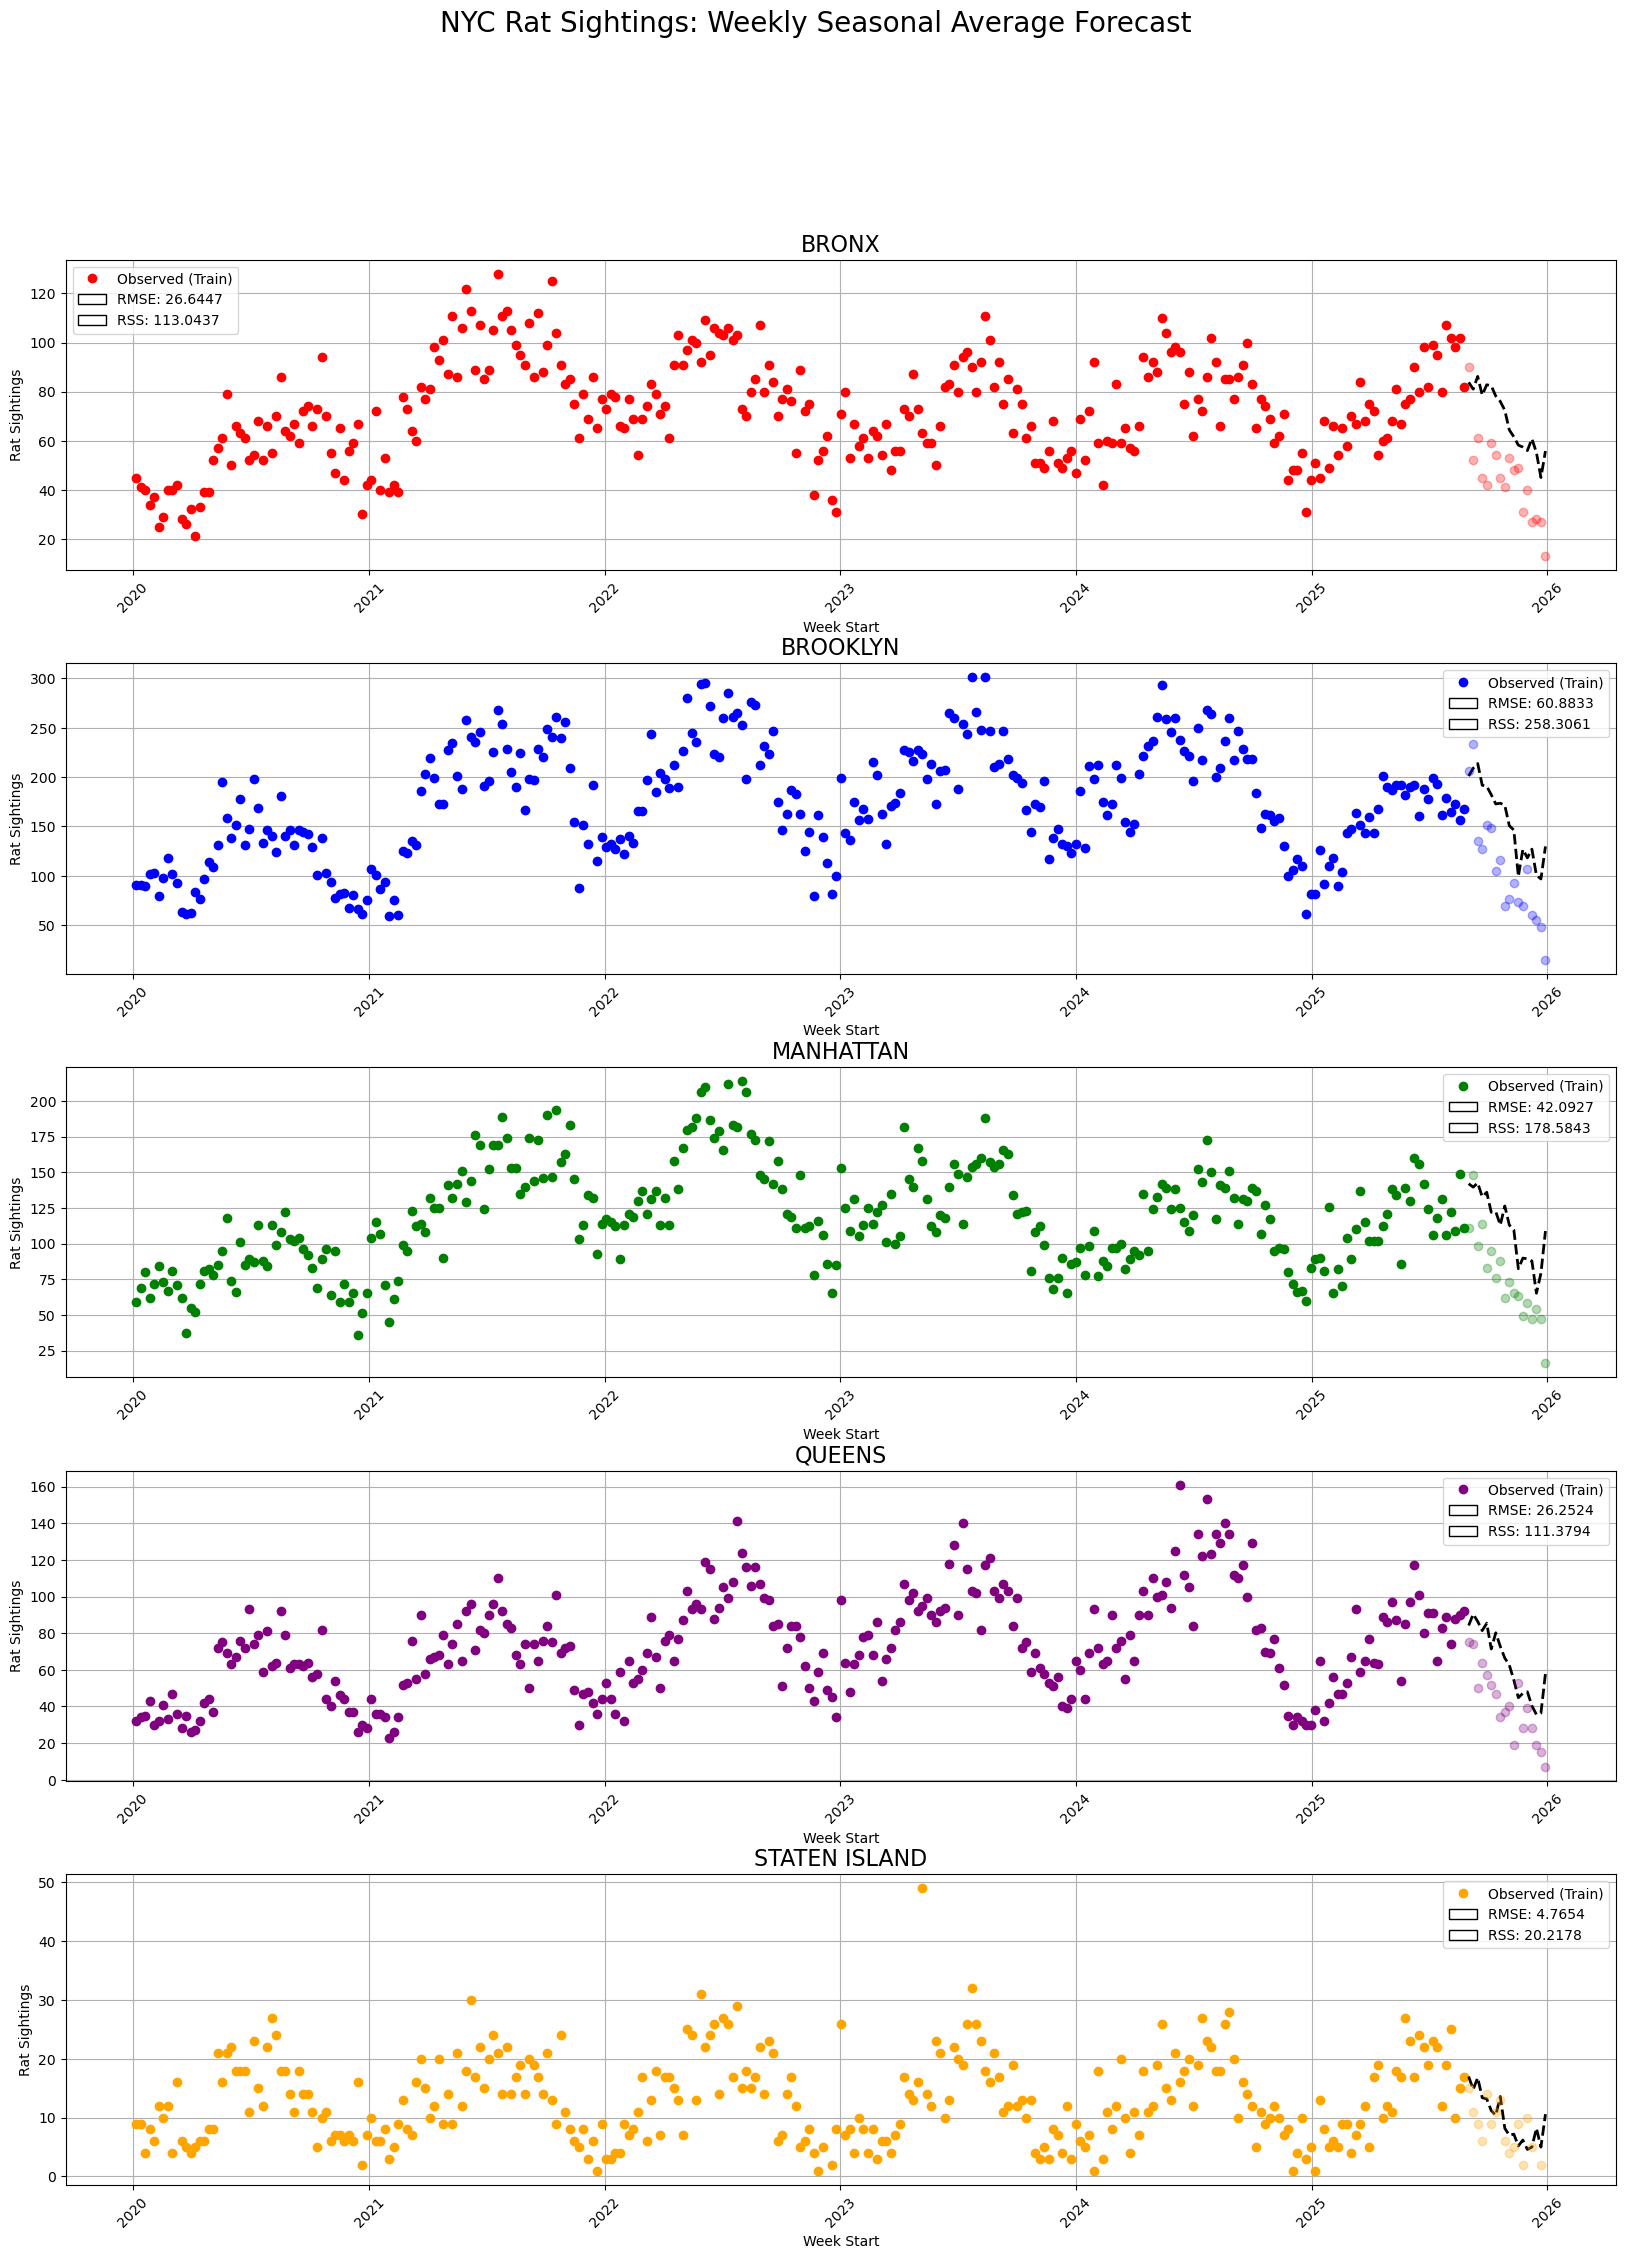

In [178]:
# Define seasonal average forecast
def seasonal_average_forecast_weekly(data, target_weeks, years_back=5):
    df = data.copy()
    df["year"] = df["week_start"].dt.year
    df["week"] = df["week_start"].dt.isocalendar().week

    forecasts = []
    for d in target_weeks:
        target_year = d.year
        target_week = d.isocalendar().week
        mask = (df["year"] >= target_year - years_back) & (df["year"] < target_year) & (df["week"] == target_week)
        forecasts.append(df.loc[mask, "count"].mean())
    return pd.Series(forecasts, index=target_weeks)


future_weeks = test["week_start"].drop_duplicates().sort_values() # future weeks to forecast


fig = plt.figure(figsize=(20, 5 * len(boroughs)))
colors = ["r", "b", "g", "purple", "orange"]

# plot for each borough

for i, borough in enumerate(boroughs):
    ax = fig.add_subplot(gs[i])

    # Training data
    b_train = train[train["borough"] == borough].copy()
    b_train = b_train.sort_values("week_start")

    # Test data
    b_test = test[test["borough"] == borough].copy()
    b_test = b_test.sort_values("week_start")

    # forecast
    forecast = seasonal_average_forecast_weekly(b_train, future_weeks, years_back=5)

    # plot the training data
    ax.plot(b_train["week_start"], b_train["count"], "o", color=colors[i % len(colors)], label="Observed (Train)")
    # plot our forecast
    ax.plot(forecast.index, forecast.values, "--", color="black", linewidth=2, label="Seasonal Avg Forecast")
    # plot the testing data
    ax.plot(b_test["week_start"], b_test["count"], "o", color=colors[i % len(colors)], alpha=0.3, label="Observed (Test)")

    # RMSE & RSS to include in legend
    actual = b_test.set_index("week_start")["count"]
    actual_aligned = actual.reindex(forecast.index, fill_value=0)
    rmse = np.sqrt(np.mean((actual_aligned - forecast.values)**2))
    rss = np.sqrt(np.sum((actual_aligned - forecast.values)**2))

    text_box = Patch(facecolor='white', edgecolor='black', label=f'RMSE: {rmse:.4f}')
    text_box2 = Patch(facecolor='white', edgecolor='black', label=f'RSS: {rss:.4f}')

    ax.set_title(f"{borough}", fontsize=16)
    ax.set_ylabel("Rat Sightings")
    ax.set_xlabel("Week Start")
    ax.grid(True)
    ax.tick_params(axis="x", rotation=45)
    ax.legend(handles=[ax.lines[0], text_box, text_box2])

plt.suptitle("NYC Rat Sightings: Weekly Seasonal Average Forecast", fontsize=20)
plt.show()

## Baseline for Monthly Borough Rat Sightings

In [179]:
monthly_borough_rs = pd.read_csv("../scr/data/cleaned_rat_sightings_data/monthly_borough_rs.csv")

In [180]:
month_cut_off = cut_off[0:7]

In [181]:
# Split train/test
train = monthly_borough_rs[(monthly_borough_rs["created_date"] >= "2020-01") & (monthly_borough_rs["created_date"] < month_cut_off)]
test = monthly_borough_rs[(monthly_borough_rs["created_date"] >= month_cut_off) & (monthly_borough_rs["created_date"] <= "2025-12")]

train["created_date"] = pd.to_datetime(train["created_date"])
test["created_date"] = pd.to_datetime(test["created_date"])

In [182]:
# Boroughs
boroughs = [b for b in monthly_borough_rs["borough"].unique() if pd.notnull(b) and b != "Unspecified"]

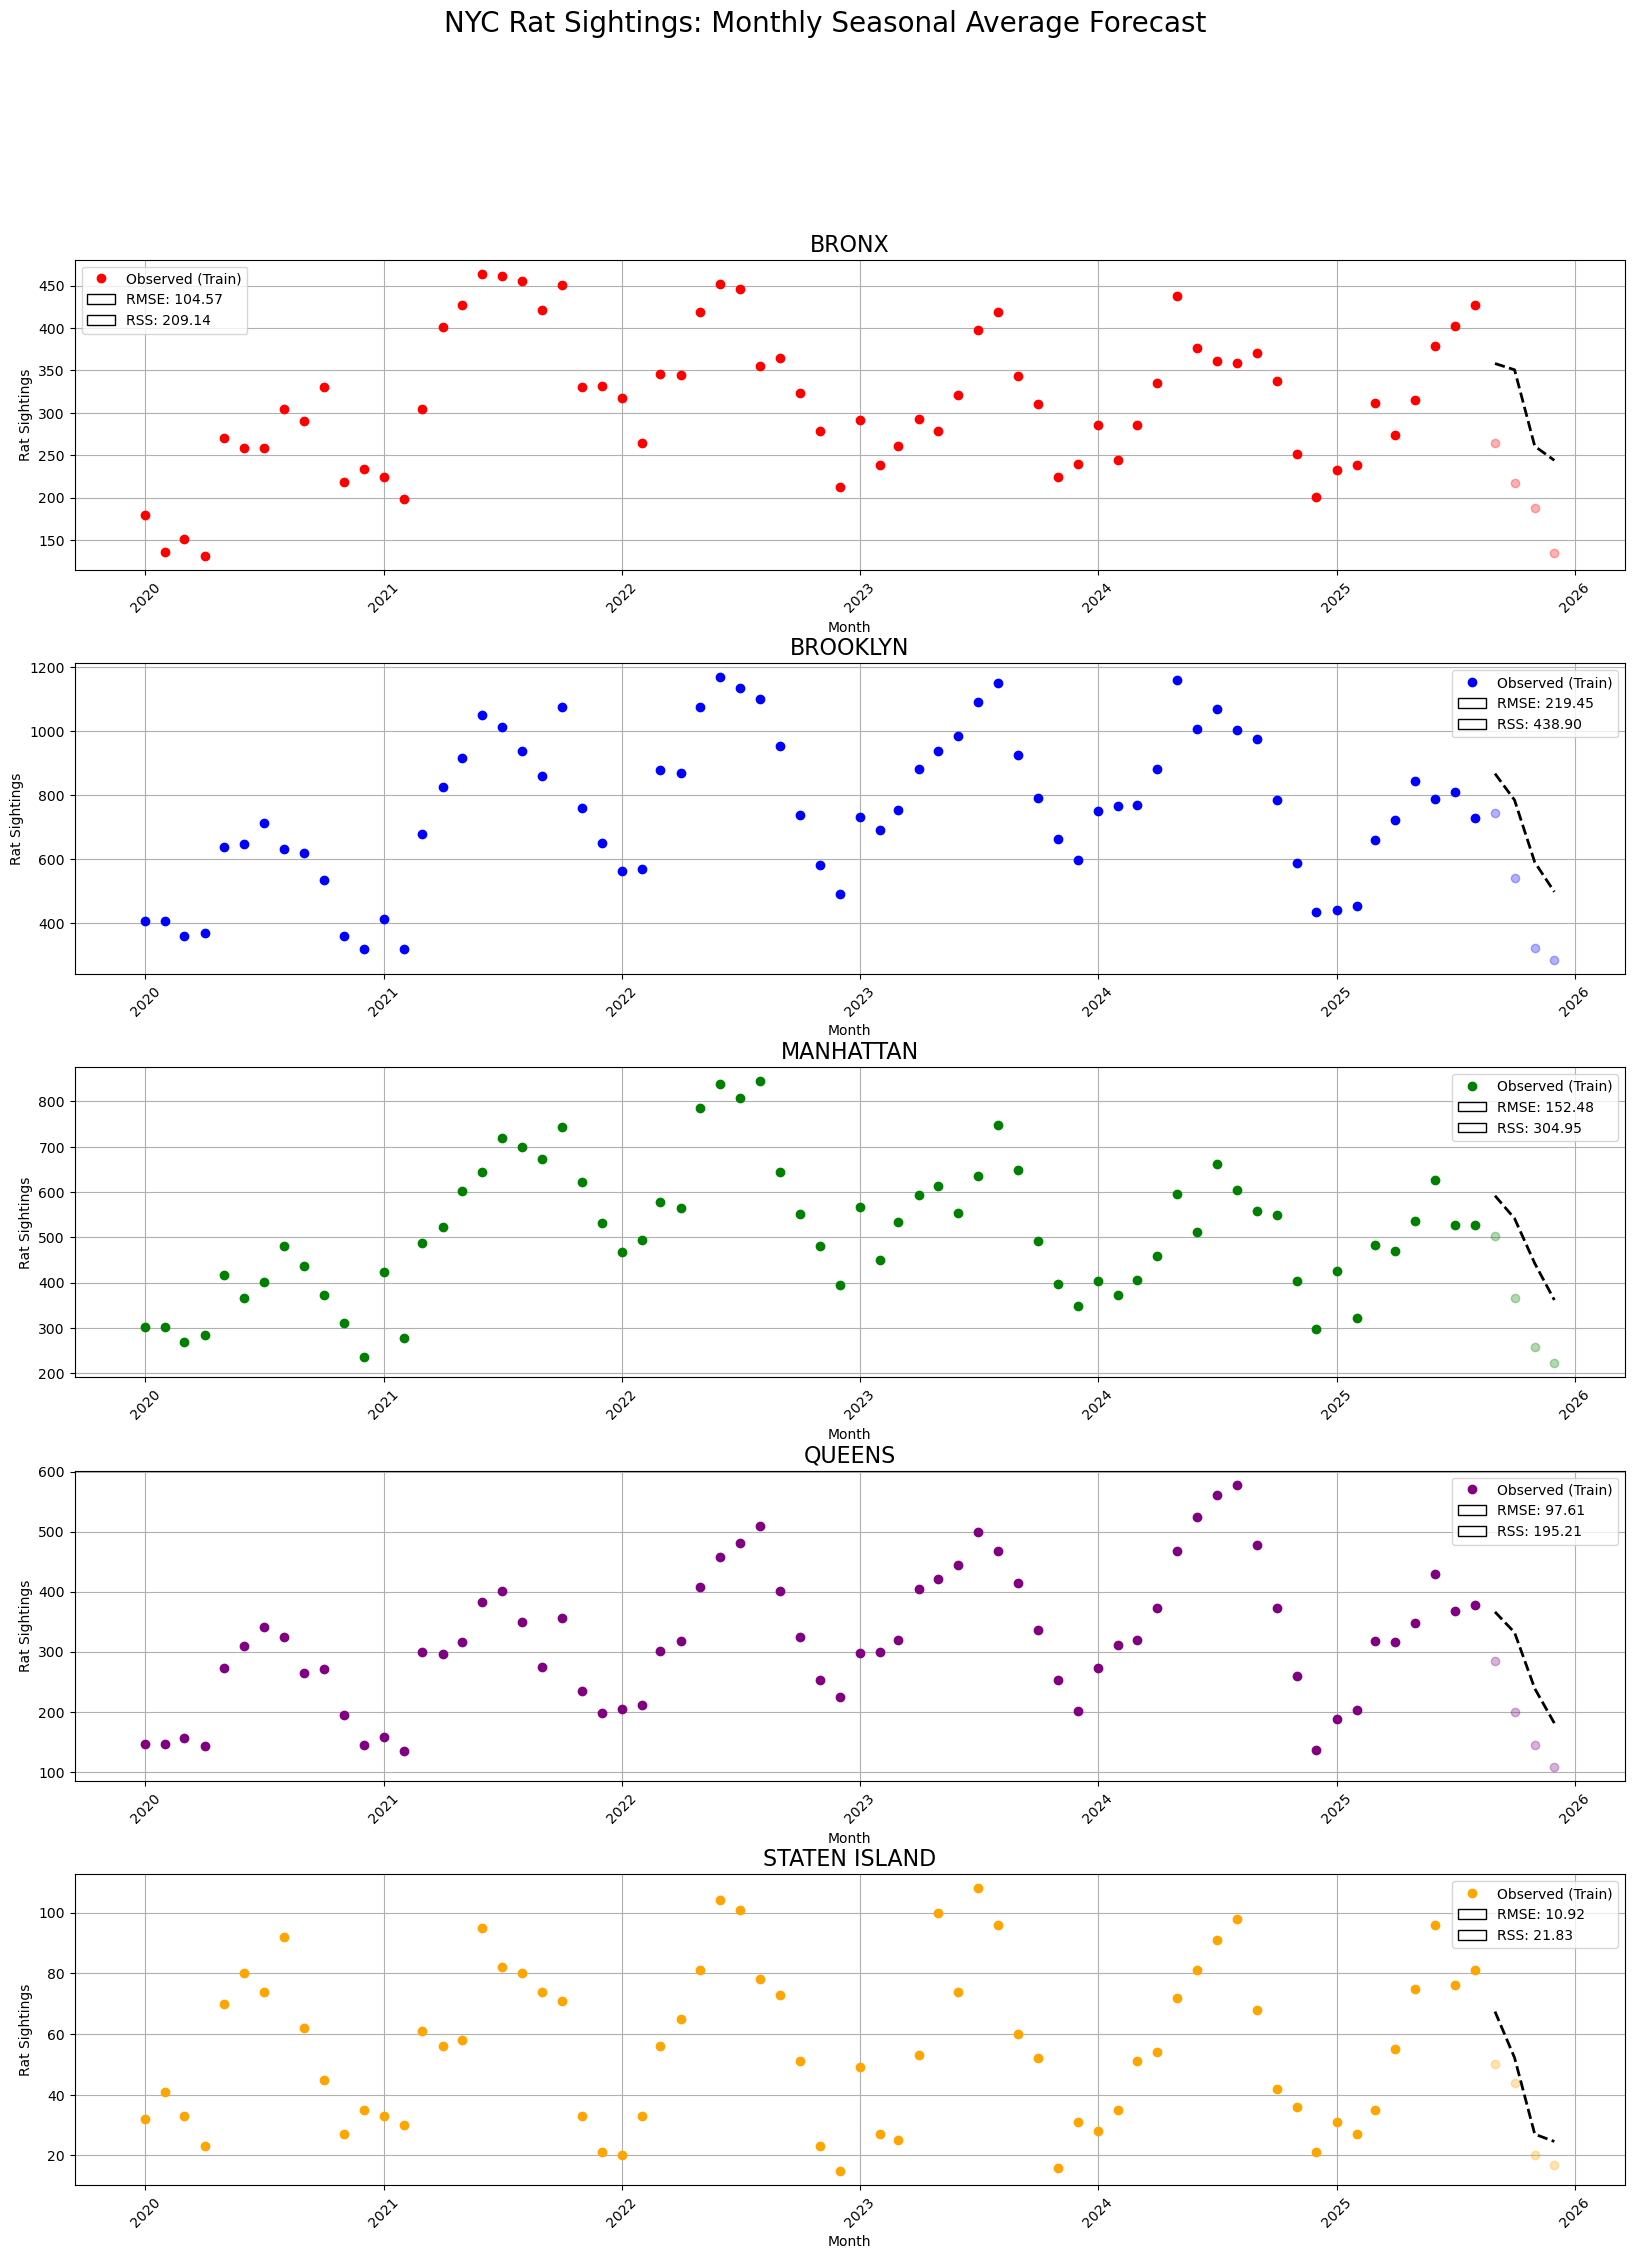

In [183]:
# Define seasonal average forecast
def seasonal_average_forecast_monthly(data, target_months, years_back=5):
    df = data.copy()
    df["year"] = df["created_date"].dt.year
    df["month"] = df["created_date"].dt.month

    forecasts = []
    for d in target_months:
        target_year = d.year
        target_month = d.month
        mask = (df["year"] >= target_year - years_back) & (df["year"] < target_year) & (df["month"] == target_month)
        forecasts.append(df.loc[mask, "count"].mean())
    return pd.Series(forecasts, index=target_months)

future_months = test["created_date"].drop_duplicates().sort_values() # future weeks to forecast


fig = plt.figure(figsize=(20, 5 * len(boroughs)))
colors = ["r", "b", "g", "purple", "orange"]

# plot for each borough

for i, borough in enumerate(boroughs):
    ax = fig.add_subplot(gs[i])

    # Training data
    b_train = train[train["borough"] == borough].copy()
    b_train = b_train.sort_values("created_date")

    # Test data
    b_test = test[test["borough"] == borough].copy()
    b_test = b_test.sort_values("created_date")

    # forecast
    forecast = seasonal_average_forecast_monthly(b_train, future_months, years_back=5)

    # plot the training data
    ax.plot(b_train["created_date"], b_train["count"], "o", color=colors[i % len(colors)], label="Observed (Train)")
    # plot our forecast
    ax.plot(forecast.index, forecast.values, "--", color="black", linewidth=2, label="Seasonal Avg Forecast")
    # plot the testing data
    ax.plot(b_test["created_date"], b_test["count"], "o", color=colors[i % len(colors)], alpha=0.3, label="Observed (Test)")

    # RMSE & RSS to include in legend
    actual = b_test.set_index("created_date")["count"]
    actual_aligned = actual.reindex(forecast.index, fill_value=0)
    rmse = np.sqrt(np.mean((actual_aligned - forecast.values)**2))
    rss = np.sqrt(np.sum((actual_aligned - forecast.values)**2))

    text_box = Patch(facecolor='white', edgecolor='black', label=f'RMSE: {rmse:.2f}')
    text_box2 = Patch(facecolor='white', edgecolor='black', label=f'RSS: {rss:.2f}')

    ax.set_title(f"{borough}", fontsize=16)
    ax.set_ylabel("Rat Sightings")
    ax.set_xlabel("Month")
    ax.grid(True)
    ax.tick_params(axis="x", rotation=45)
    ax.legend(handles=[ax.lines[0], text_box, text_box2])

plt.suptitle("NYC Rat Sightings: Monthly Seasonal Average Forecast", fontsize=20)
plt.show()

## Baseline for Daily Zip Rat Sightings

We try to fit a  Seasonal Average Forecast Model to the number of rat sightings in particular ZIP codes.

For looking up ZIP codes, one can use https://www.unitedstateszipcodes.org/ to quickly look up the location of each ZIP code and see which ZIP codes are adjacent.

The code below does the following: 

(a) It picks out a random ZIP code that has appeared in our data

(b) It produces a list of ZIP codes which are "adjacent" to it i.e. within a 1.5km radius of the center of the chosen random ZIP code.

(c) For each of the ZIP codes in the list (including the first randomly chosen ZIP code), we provide a Seasonal Average Forecast. It is uses data up to the cut_off to forecast rat sightings from cut_off until 2025-12-31. Since we expect to give whole number estimates of the number of rat sightings, we have both (i) the Seasonal Average Forecast as is and (ii) a Seasonal Average Forecast where we round each forecast to the nearest integer.



In [184]:
daily_zip_rs = pd.read_csv("../scr/data/cleaned_rat_sightings_data/daily_zip_rs.csv")

In [185]:
daily_zip_rs

created_date      zip  count
0       2020-01-01  10026.0      1
1       2020-01-01  10031.0      1
2       2020-01-01  10035.0      1
3       2020-01-01  10128.0      1
4       2020-01-01  10314.0      1
...            ...      ...    ...
92213   2025-12-30  11225.0      1
92214   2025-12-30  11226.0      1
92215   2025-12-30  11229.0      1
92216   2025-12-30  11237.0      1
92217   2025-12-30  11357.0      1

[92218 rows x 3 columns]

In [186]:
# Get unique ZIP codes (dropping NaNs just in case)
unique_zips = daily_zip_rs['zip'].unique().tolist()
random_zip = random.choice(unique_zips)

In [187]:
import csv
import math

# Haversine distance (km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)

    a = (
        math.sin(dphi / 2) ** 2
        + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2) ** 2
    )
    return 2 * R * math.atan2(math.sqrt(a), math.sqrt(1 - a))


def load_zip_data(csv_path):
    zips = {}
    with open("../scr/cleaning/map_data_for_cleaning/uszips.csv", newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            zips[row["zip"]] = {
                "lat": float(row["lat"]),
                "lng": float(row["lng"]),
            }
    return zips


def adjacent_zipcodes(target_zip, zip_data, radius_km=15):
    if target_zip not in zip_data:
        raise ValueError("ZIP code not found")

    lat1 = zip_data[target_zip]["lat"]
    lon1 = zip_data[target_zip]["lng"]

    neighbors = []

    for zip_code, data in zip_data.items():
        if zip_code == target_zip:
            continue

        dist = haversine(lat1, lon1, data["lat"], data["lng"])
        if dist <= radius_km:
            neighbors.append(zip_code)

    return neighbors

zip_data = load_zip_data("../scr/cleaning/map_data_for_cleaning/uszips.csv")


adjacent = adjacent_zipcodes(str(int(random_zip)), zip_data, radius_km=1.5)

adjacent.append(str(int(random_zip)))

adjacent = [int(x) for x in adjacent]

print(adjacent)

[10019, 10024, 10069, 10153, 10023]


Here are the baseline models for ZIP codes within 1.5km to ZIP 10023


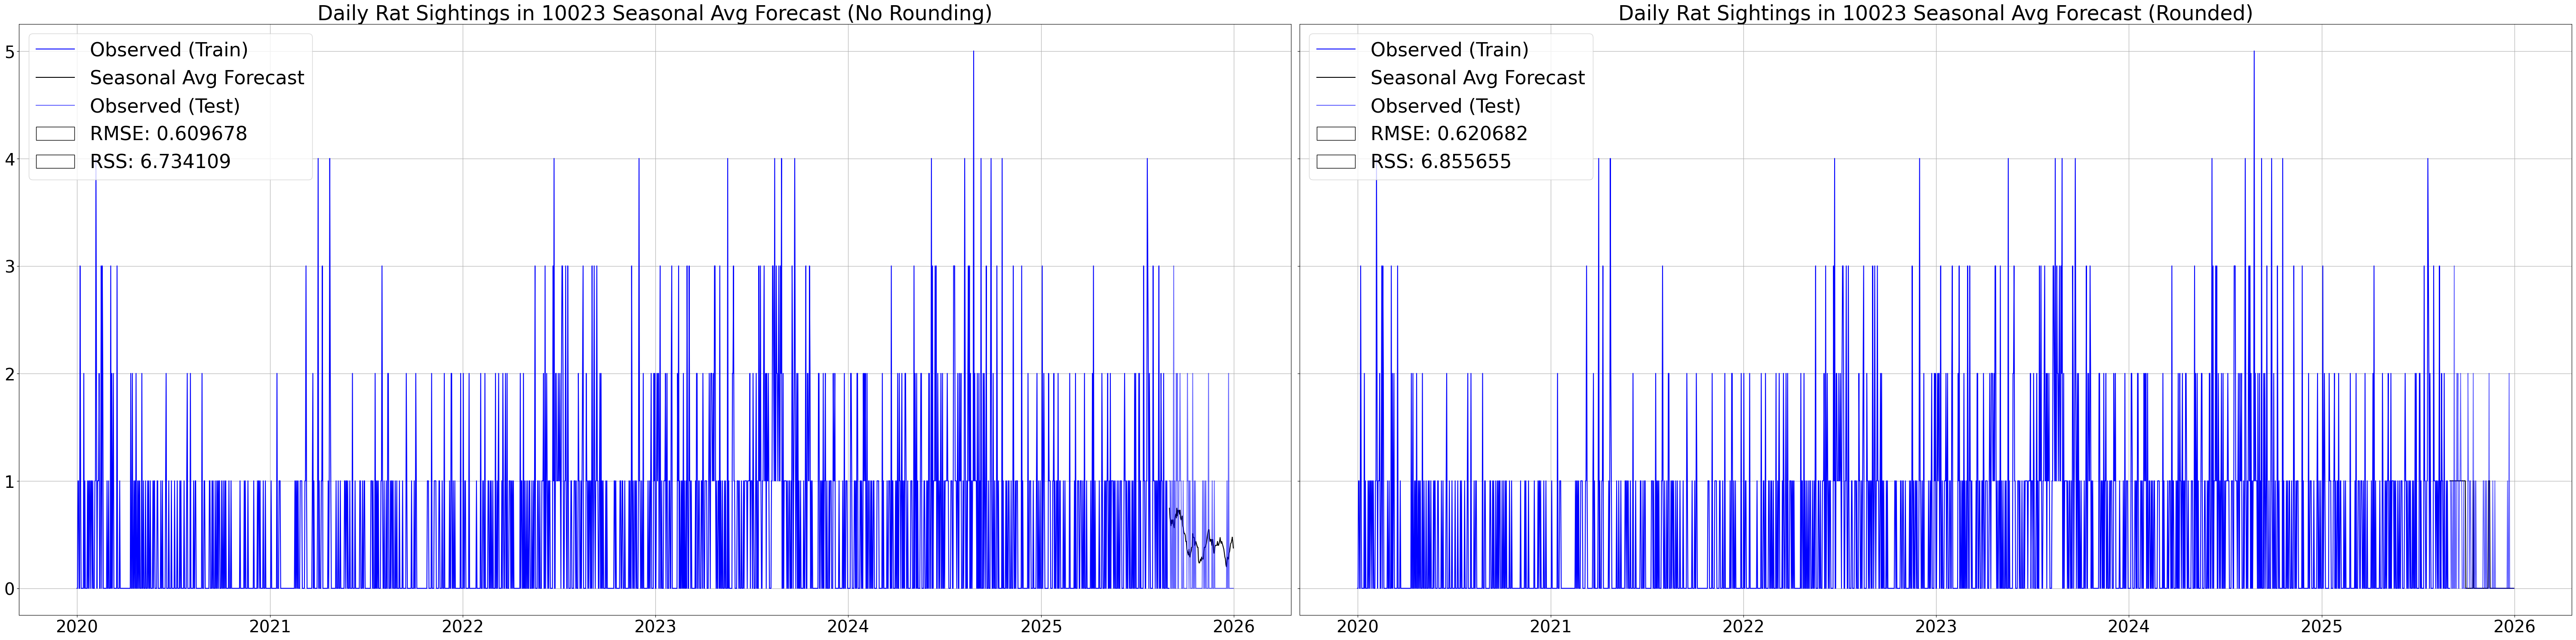

No rats were sighed in ZIP 10023


In [188]:
print(f"Here are the baseline models for ZIP codes within 1.5km to ZIP {int(random_zip)}")

for adj_zip in adjacent[::-1]:

    zipran_rs = daily_zip_rs[daily_zip_rs['zip']==adj_zip]

    if len(zipran_rs)==0:
        print(f"No rats were sighed in ZIP {int(random_zip)}")
        break

    # Ensure created_date is a datetime type
    zipran_rs['created_date'] = pd.to_datetime(zipran_rs['created_date'])
    # Set created_date as index
    zipran_rs = zipran_rs.set_index('created_date')
    # Reindex to a continuous daily date range
    full_index = pd.date_range(start=zipran_rs.index.min(), end=zipran_rs.index.max(), freq='D')
    zipran_rs = zipran_rs.reindex(full_index, fill_value=0)
    # Reset index and rename columns
    zipran_rs = zipran_rs.reset_index().rename(columns={'index': 'created_date'})
    
    zipran_rs_train = zipran_rs[zipran_rs['created_date']<cut_off]
    zipran_rs_test = zipran_rs[zipran_rs['created_date']>=cut_off]
    nrs_train = zipran_rs_train.copy()
    nrs_test = zipran_rs_test.copy()

    full_range_train = pd.date_range(start="2020-01-01", end=before_cut_off, freq="D")

    nrs_train = nrs_train.set_index("created_date").reindex(full_range_train, fill_value=0).rename_axis("created_date").reset_index()

    full_range_test = pd.date_range(start=cut_off, end="2025-12-31", freq="D")

    nrs_test = nrs_test.set_index("created_date").reindex(full_range_test, fill_value=0).rename_axis("created_date").reset_index()

    def seasonal_average_forecast(data, target_dates, years_back=5, day_window=5):
        df = data.copy()
        df["created_date"] = pd.to_datetime(df["created_date"])
        df["doy"] = df["created_date"].dt.dayofyear
        df["year"] = df["created_date"].dt.year

        forecasts = []

        for target_date in pd.to_datetime(target_dates):
            target_doy = target_date.dayofyear
            target_year = target_date.year

            mask = ((df["year"] >= target_year - years_back) & (df["year"] < target_year) & (np.abs(df["doy"] - target_doy) <= day_window))

            forecasts.append(df.loc[mask, "count"].mean())

        return pd.Series(forecasts, index=pd.to_datetime(target_dates))

    future_dates = pd.to_datetime(nrs_test["created_date"])

    forecast_raw = seasonal_average_forecast(nrs_train, future_dates, years_back=5)

    forecast_rounded = forecast_raw.round()

    fig, axes = plt.subplots(1, 2, figsize=(60, 15), sharey=True)

    plot_configs = [(forecast_raw, "Seasonal Avg Forecast (No Rounding)"), (forecast_rounded, "Seasonal Avg Forecast (Rounded)")]

    for ax, (forecast, subtitle) in zip(axes, plot_configs):

        # Plot training data
        ax.plot(nrs_train["created_date"], nrs_train["count"], color="blue", label="Observed (Train)")

        # Plot forecast
        ax.plot(forecast.index, forecast.values, color="black", label="Seasonal Avg Forecast")

        # Plot test data
        ax.plot(nrs_test["created_date"], nrs_test["count"], color="blue", alpha=0.6, label="Observed (Test)")

        # Metrics
        rmse = np.sqrt(np.mean((nrs_test["count"].values - forecast.values) ** 2))
        rss = np.sqrt(np.sum((nrs_test["count"].values - forecast.values) ** 2))

        # Legend with metrics
        metric_rmse = Patch(facecolor="white", edgecolor="black", label=f"RMSE: {rmse:.6f}")
        metric_rss = Patch(facecolor="white", edgecolor="black", label=f"RSS: {rss:.6f}")

        handles, labels = ax.get_legend_handles_labels()
        handles.extend([metric_rmse, metric_rss])

        ax.legend(handles=handles, fontsize=32)
        ax.set_title(f"Daily Rat Sightings in {int(adj_zip)} {subtitle}", fontsize=34)

        ax.grid(True)
        ax.tick_params(axis="x", labelsize=28)
        ax.tick_params(axis="y", labelsize=28)

    plt.tight_layout()
    plt.show()

In [189]:
from sklearn.model_selection import TimeSeriesSplit

Our cross-validation will work as follows. 

We first train on data from 2020-01-01 to 2020-12-31, and test using 2021-01-01 to 2021-12-31. Then we train on 2020-01-01 to 2021-12-13 and test from 2022-01-01 to 2022-12-13. We continue until we test on 2025-01-01 to 2025-12-13. 

In other words, our forecasting horizon is 1 year and so we have 6 splits.

In [190]:
kfold = TimeSeriesSplit(n_splits = 6,
                           test_size = 365)

In [191]:
df = rs.copy()
df["created_date"] = pd.to_datetime(df["created_date"])


# Convert dates to ordinal numbers
date_index = df["created_date"].map(pd.Timestamp.toordinal)

df = (
    df
    .sort_values("created_date", ascending=True)
    .reset_index(drop=True)
)

tscv = TimeSeriesSplit(n_splits=6)

for fold, (train_idx, test_idx) in enumerate(tscv.split(date_index)):
    train_dates = df.iloc[train_idx]["created_date"]
    test_dates = df.iloc[test_idx]["created_date"]
    print(f"Fold {fold + 1}")
    print("Train:", train_dates.min(), "→", train_dates.max())
    print("Test: ", test_dates.min(), "→", test_dates.max())
    print()

Fold 1
Train: 2020-01-01 03:24:58 → 2021-03-24 06:53:51
Test:  2021-03-24 07:35:07 → 2021-11-30 15:24:22

Fold 2
Train: 2020-01-01 03:24:58 → 2021-11-30 15:24:22
Test:  2021-11-30 15:43:06 → 2022-08-19 15:25:32

Fold 3
Train: 2020-01-01 03:24:58 → 2022-08-19 15:25:32
Test:  2022-08-19 15:46:26 → 2023-06-16 21:52:19

Fold 4
Train: 2020-01-01 03:24:58 → 2023-06-16 21:52:19
Test:  2023-06-16 23:03:03 → 2024-04-05 04:32:26

Fold 5
Train: 2020-01-01 03:24:58 → 2024-04-05 04:32:26
Test:  2024-04-05 04:33:49 → 2025-01-04 08:42:15

Fold 6
Train: 2020-01-01 03:24:58 → 2025-01-04 08:42:15
Test:  2025-01-04 09:29:23 → 2025-12-30 20:18:16



# SARIMA Models

We might consider a SARIMA model. However, it is by nature, only good at forecasting with a short horizon. It would not be ideal for forecasting a year out. However, it we are simply forcasting for a a month in advance, then it does a pretty good job.

In [192]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

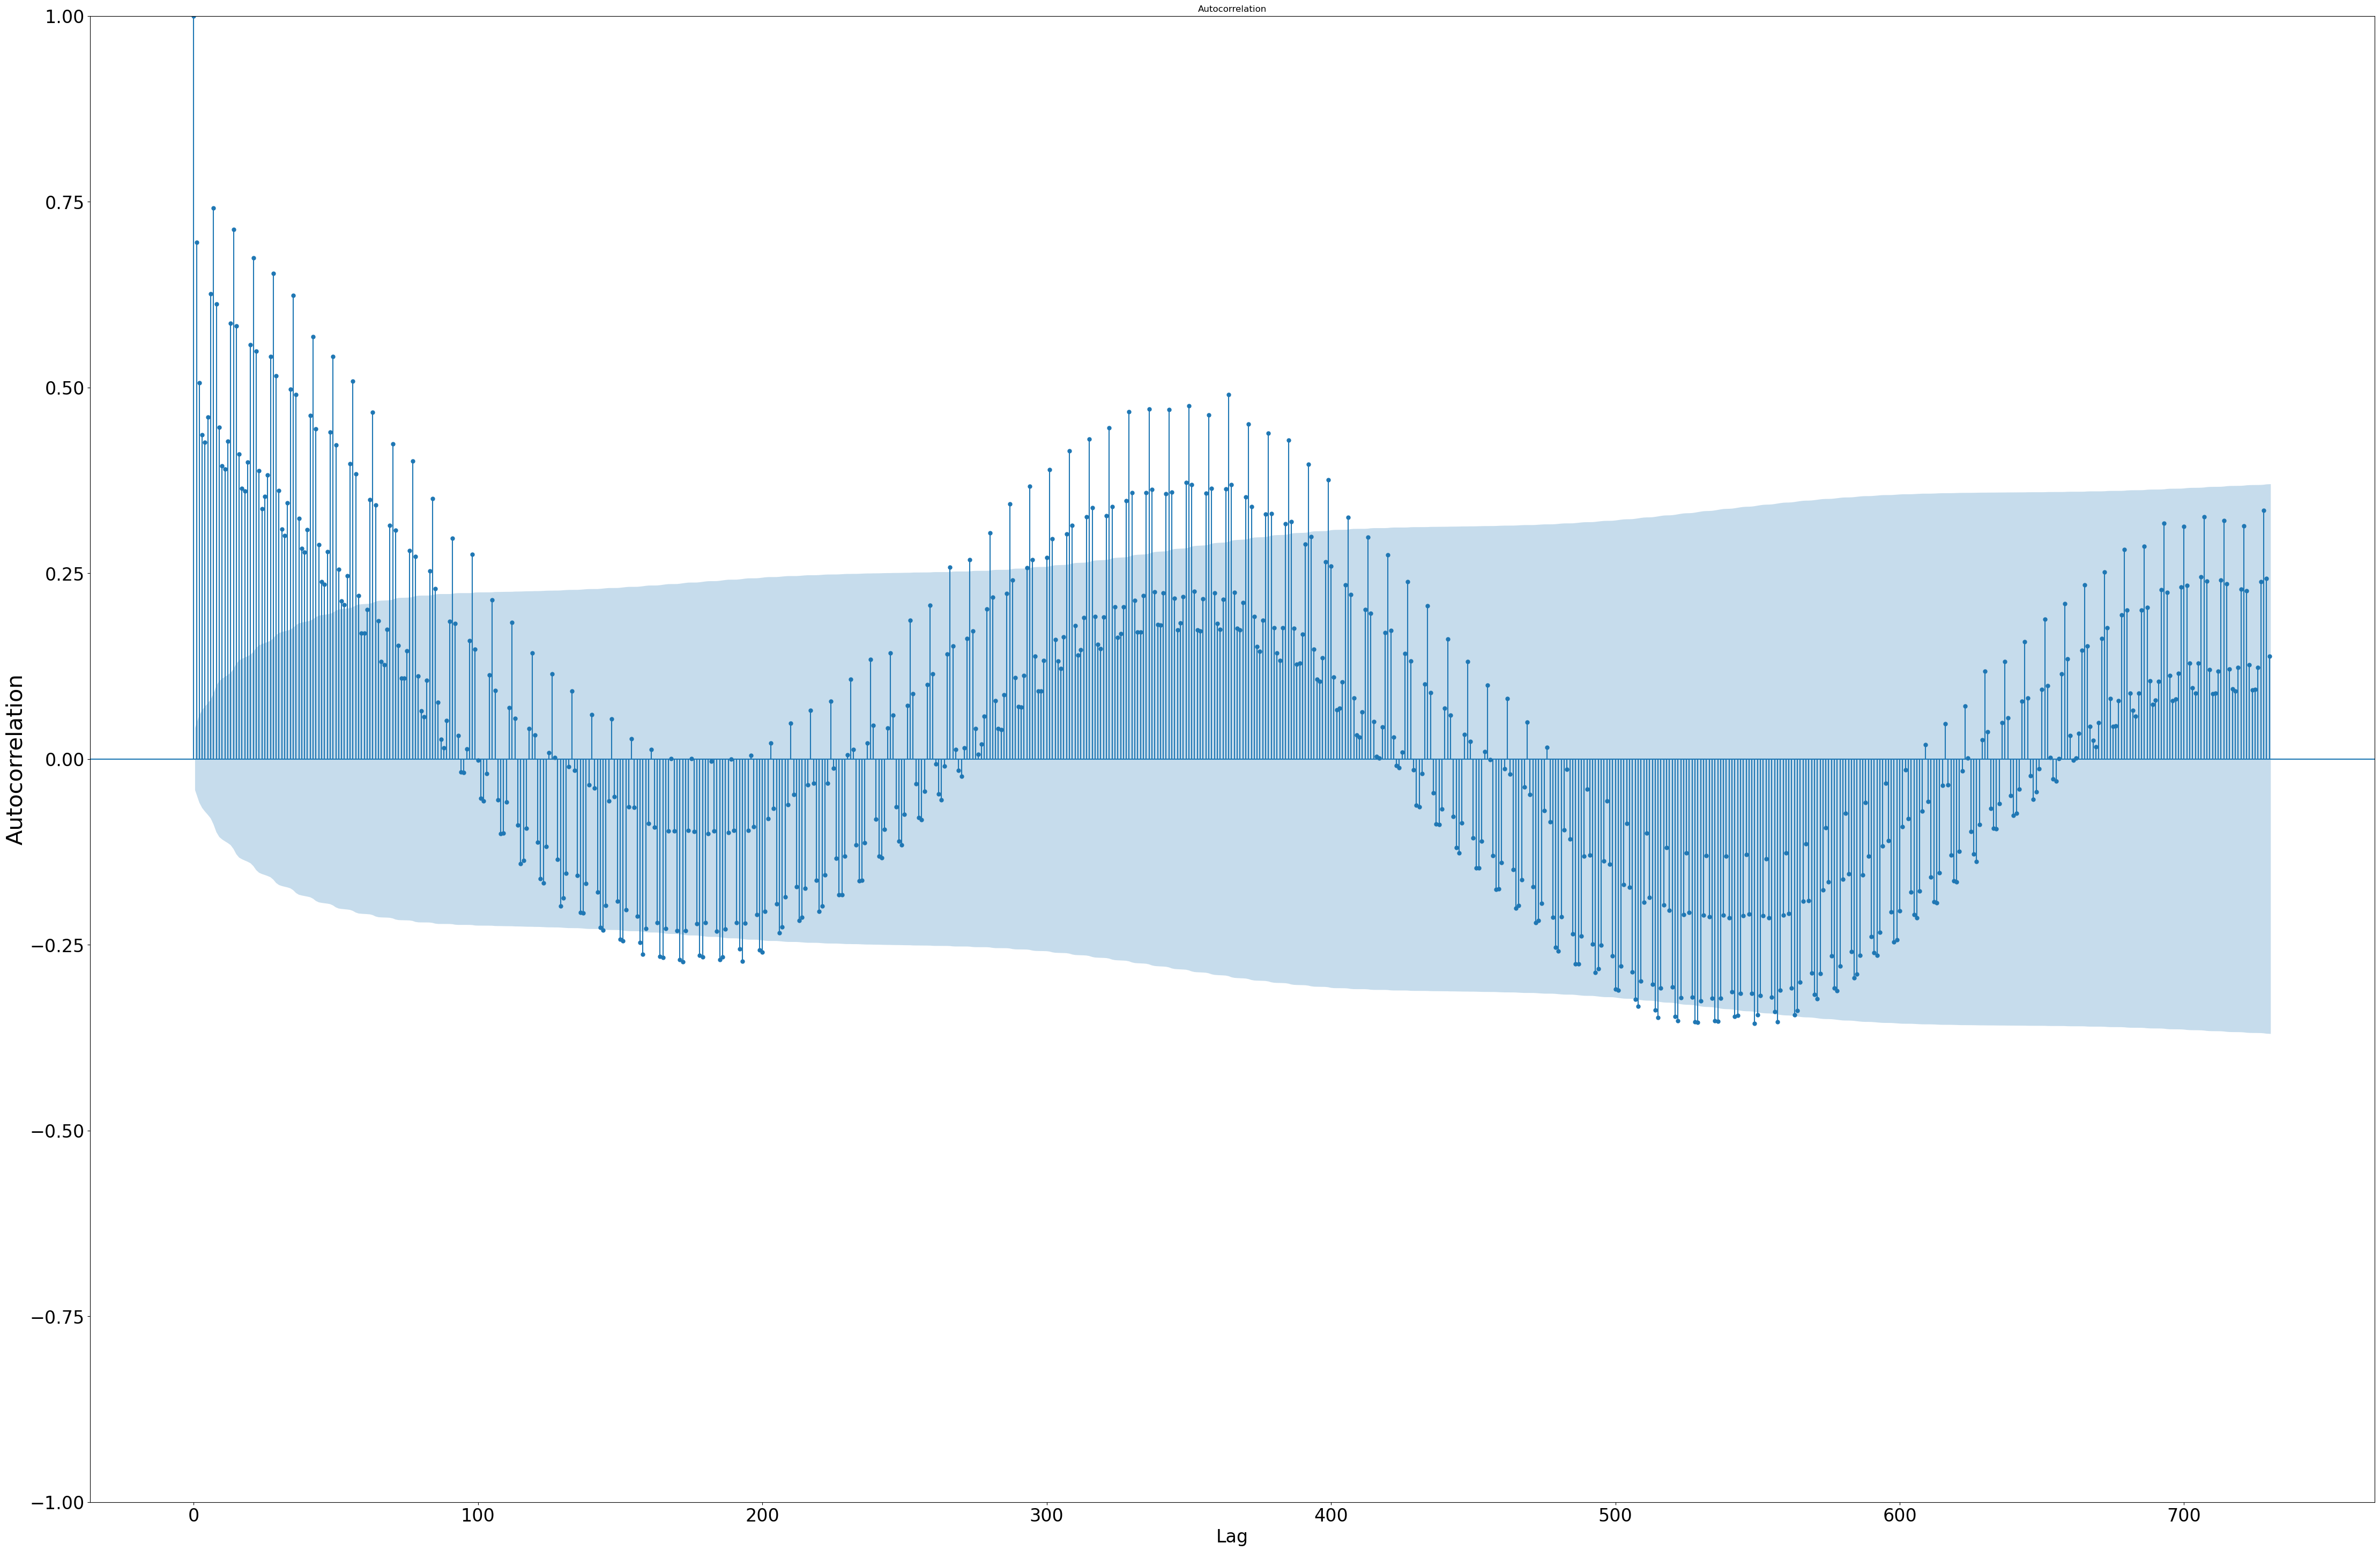

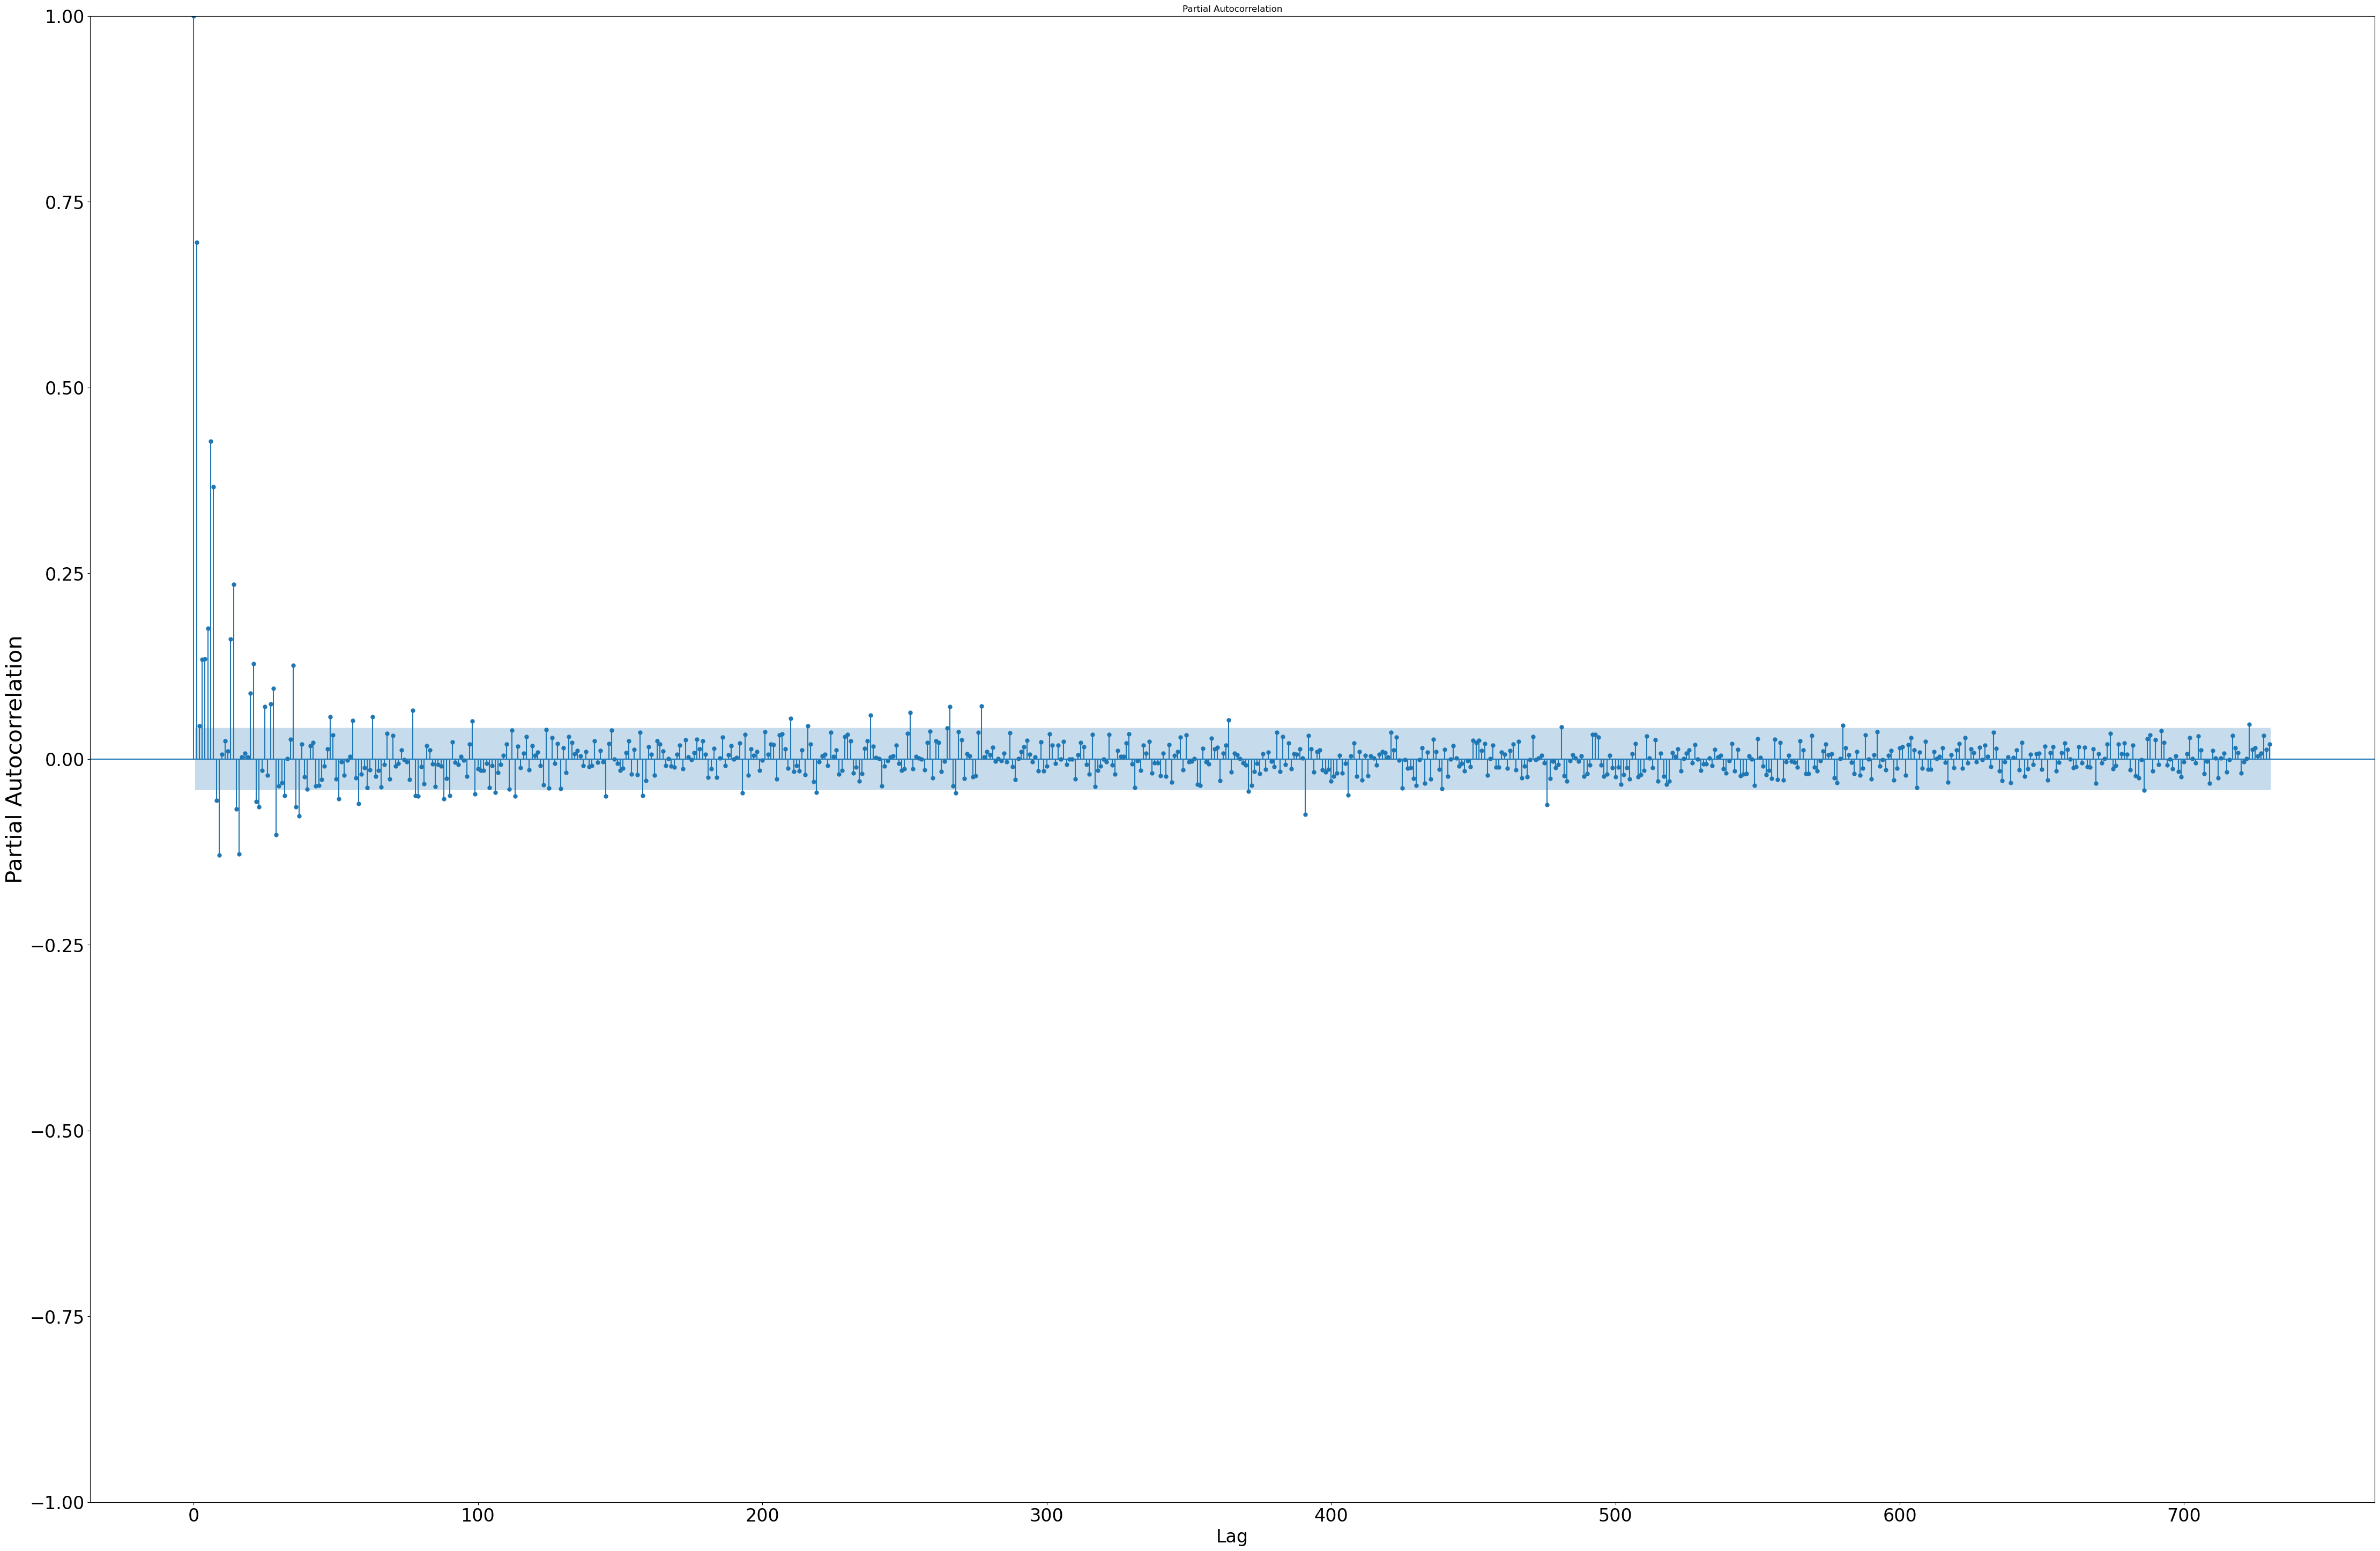

In [193]:
cdate_rat = rs.groupby(rs['created_date'].dt.date).size().reset_index(name='count')


fig, ax = plt.subplots(1, 1, figsize=(55,36))
sm.graphics.tsa.plot_acf(cdate_rat['count'], 
                         lags = 365*2,
                         ax=ax)
plt.xlabel("Lag",fontsize=24)
plt.ylabel("Autocorrelation",fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(55,36))
sm.graphics.tsa.plot_pacf(cdate_rat['count'], 
                         lags = 365*2,
                         ax=ax)
plt.xlabel("Lag",fontsize=24)
plt.ylabel("Partial Autocorrelation",fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [194]:
import statsmodels.tsa.api as sm
from pmdarima import auto_arima

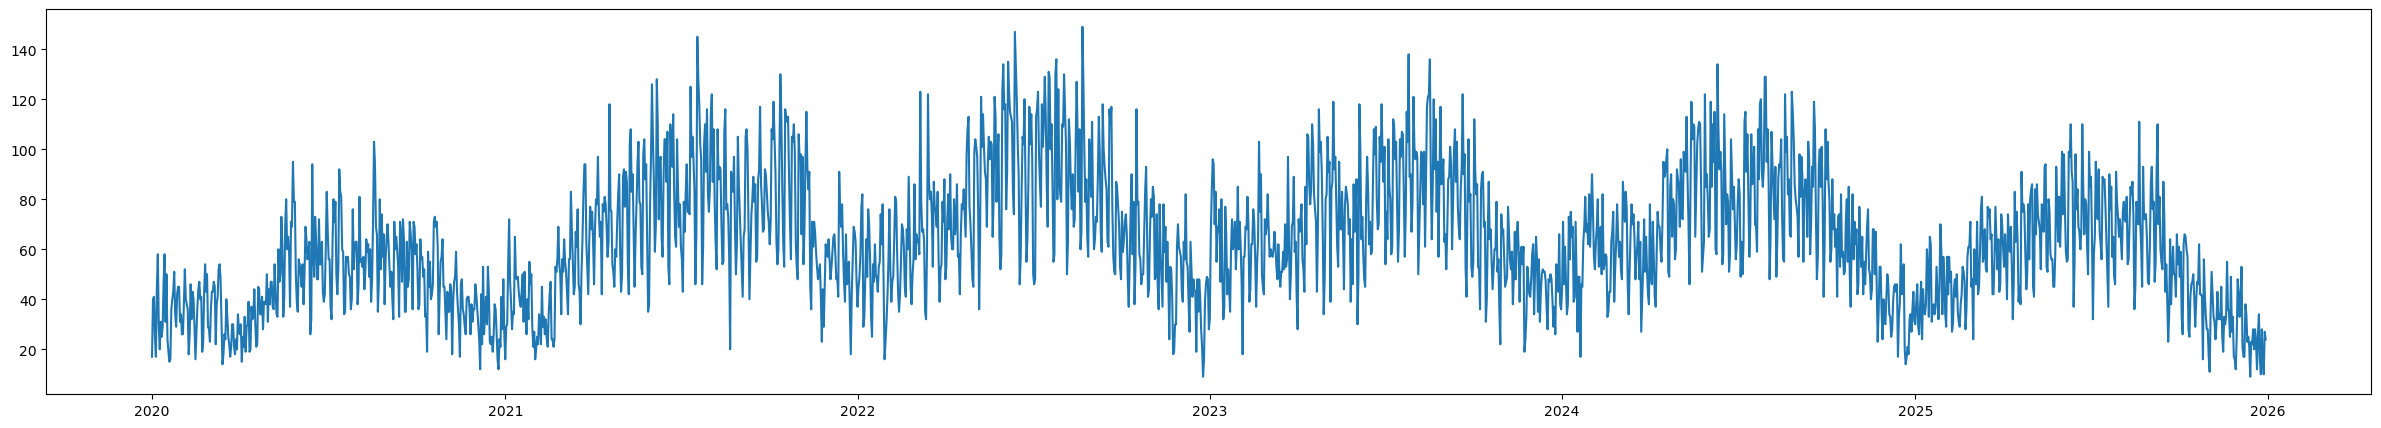

In [195]:
y = rs.groupby([rs['created_date'].dt.date]).size().reset_index(name='count')

full_range = pd.date_range(
    start="2020-01-01",
    end=y['created_date'].max(),
    freq='D'
)

# reindex and fill missing dates with 0
y = (
    y
    .set_index('created_date')
    .reindex(full_range, fill_value=0)
    .rename_axis('created_date')
    .reset_index()
)

plt.figure(figsize=(30,5))
plt.plot(y['created_date'], y['count'])
plt.show()

In the codebloc below, we have set the cuf off date for our training/test data as 2025-01-01. If one continues running this, then one finds that the SARIMA model gives a really bad prediction. 

However, if one changes it to 2025-12-01 and try to forcast only a month out, then the model does an okay job.

In [196]:
y_train = y[y['created_date']< cut_off]
y_test = y[y['created_date']>= cut_off]

In [197]:
# A SARIMA model is not wise for seasonality of 1 year with daily data. Picking m = 7 is NOT appropriate here.
# See https://alkaline-ml.com/pmdarima/2.0.1/tips_and_tricks.html?highlight=seasonal


# Uncomment the line below to find AIC minimizing values to use for the ARIMA model. 
# In current state of this code, the optimal choice is (2,1,1)(1,0,1).
z = y_train['count'].to_numpy()
#auto_arima(z, trace=True, error_action="ignore", stepwise=True, seasonal=True, m = 7)

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                 2070
Model:             ARIMA(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -8308.110
Date:                         Thu, 26 Feb 2026   AIC                          16628.220
Time:                                 12:34:48   BIC                          16662.029
Sample:                                      0   HQIC                         16640.613
                                        - 2070                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2457      0.025      9.983      0.000       0.197       0.294
ar.L2          0.0646      0.024      2.690      0.007     

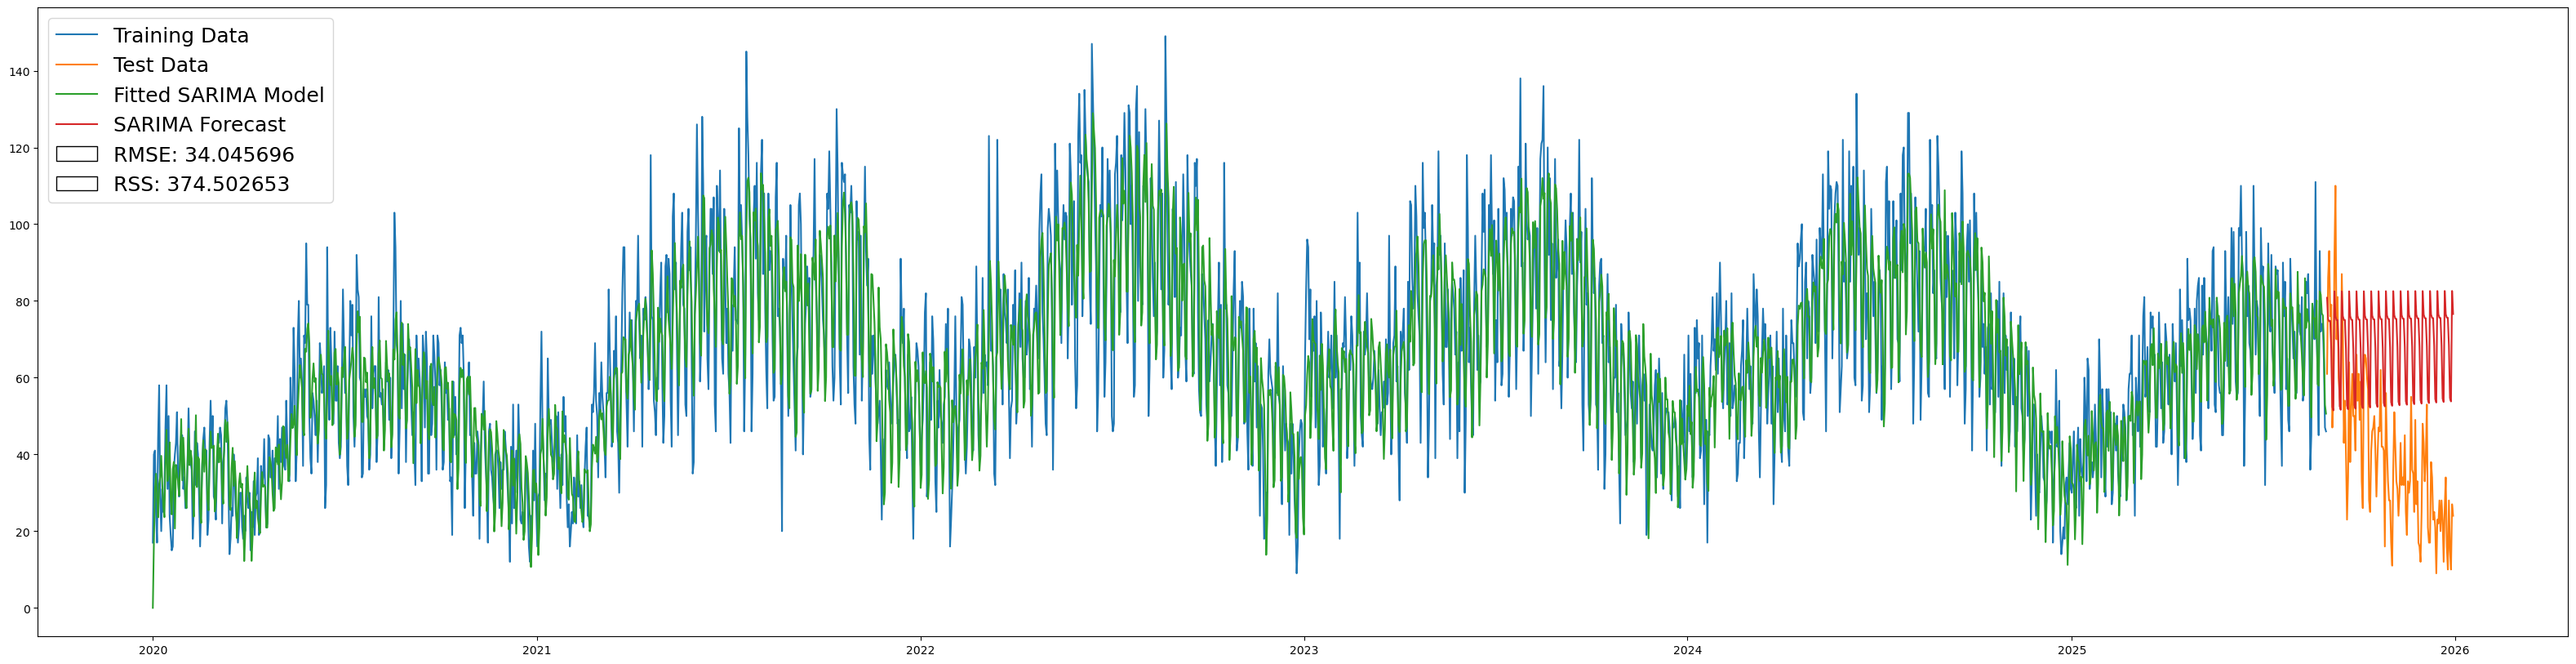

In [198]:
model = sm.ARIMA(z, order = (2, 1, 1), seasonal_order=(1,0,1,7)).fit()
print(model.summary())
plt.figure(figsize=(40,10))
plt.plot(y_train['created_date'], y_train['count'], label="Training Data")
plt.plot(y_test['created_date'], y_test['count'], label="Test Data")

plt.plot(y_train['created_date'], model.fittedvalues, label="Fitted SARIMA Model")
plt.plot(y_test['created_date'], model.forecast(len(y_test['created_date'])), label="SARIMA Forecast")


rmse = np.sqrt(np.mean((y_test['count'] - model.forecast(len(y_test['created_date'])))**2))
rss = np.sqrt(np.sum((y_test['count'] - model.forecast(len(y_test['created_date'])))**2))
text_box = Patch(facecolor='white', edgecolor='black', label=f'RMSE: {rmse:.2f}')
text_box2 = Patch(facecolor='white', edgecolor='black', label=f'RSS: {rss:.2f}')

handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([text_box, text_box2])
labels.extend([f"RMSE: {rmse:.6f}", f"RSS: {rss:.6f}"])

plt.legend(handles=handles, labels=labels, fontsize=18)
plt.show()

# Nonlinear Regression on Fourier Series Models

In [199]:
rs['created_date'] = pd.to_datetime(rs['created_date']) 
rs['closed_date'] = pd.to_datetime(rs['closed_date'])
rs['resolution_action_updated_date'] = pd.to_datetime(rs['resolution_action_updated_date'])


# Start by cutting off datas before 2020-01-01 and after 2025-12-31.

rs = rs[rs['created_date']<='2025-12-31']
rs = rs[rs['created_date']>='2020-01-01']


day_before_obj = datetime.datetime.strptime(cut_off, '%Y-%m-%d') - datetime.timedelta(days=1)
# Convert back to string (date only)
before_cut_off = day_before_obj.strftime('%Y-%m-%d')

rs_train = rs[rs['created_date']<cut_off]
rs_test = rs[rs['created_date']>=cut_off]


nrs_test = rs_test.groupby([rs_test['created_date'].dt.date]).size().reset_index(name='count')

nrs_train = rs_train.groupby([rs_train['created_date'].dt.date]).size().reset_index(name='count')


In [200]:
df_train = nrs_train
df_test = nrs_test

We can use nonlinear regression and try to fit a model of the following form
$$
f(t) = \beta_0 + \beta_1t + \sum_{j=1}^T \left[ \phi_j \cos\left(\frac{2j\pi}{365} t\right) + \psi_j\sin\left(\frac{2j\pi}{365} t\right) \right]
$$
with a linear component to capture any upward trend, and a Fourier polynomial term to capture the periodic part. 

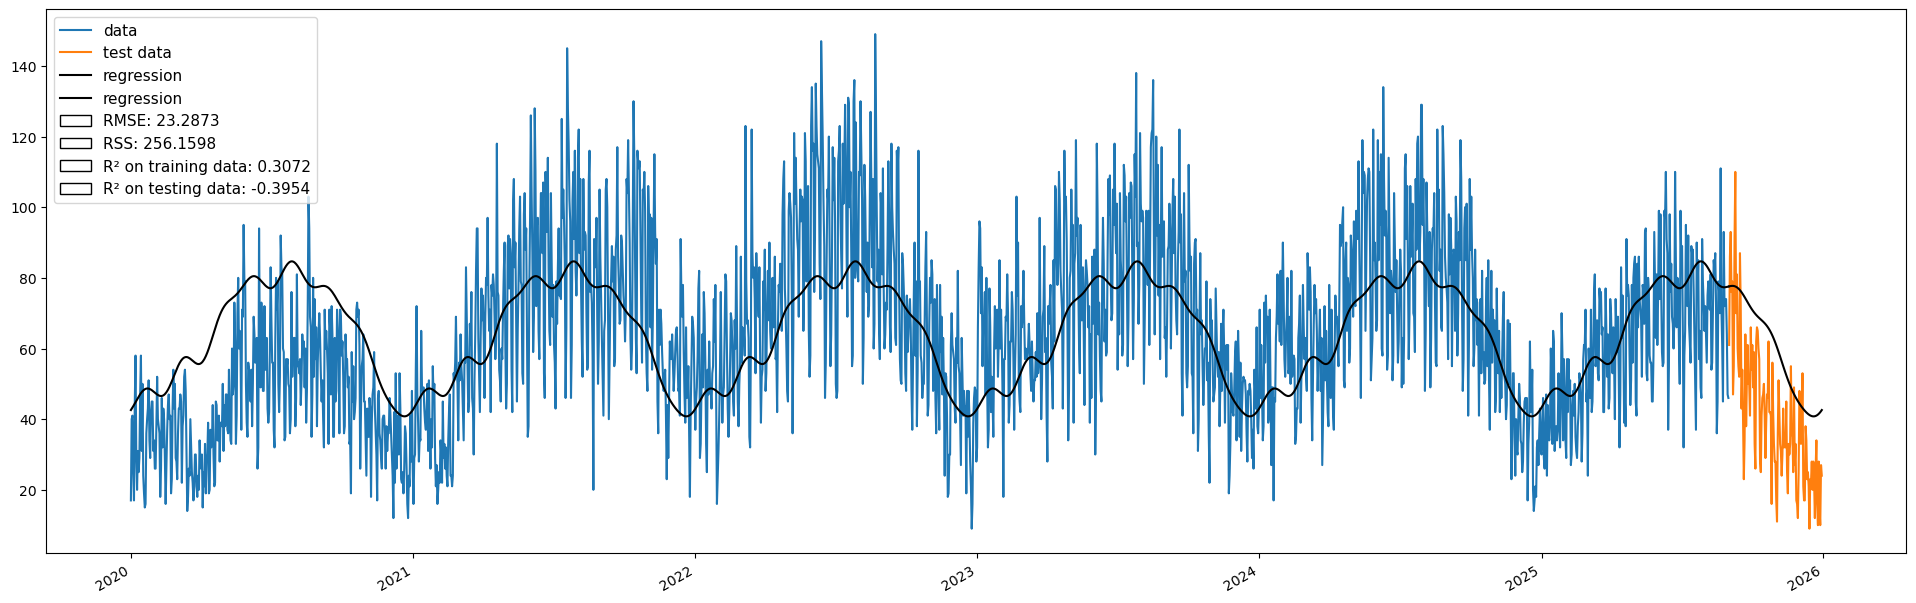

In [201]:
from sklearn.linear_model import LinearRegression


T = 9 # picks out the number of fourier terms

train_times = df_train.index.values
cosines = np.stack([np.cos(2*np.pi*train_times*j/365) for j in range(1,T)]  , axis = 1)
sines = np.stack([np.sin(2*np.pi*train_times*j/365) for j in range(1,T)]  , axis = 1)
train_features = np.concatenate([cosines, sines], axis = 1)

lr = LinearRegression()
lr.fit(train_features,df_train['count'])
lr_train_preds = lr.predict(train_features)





test_times = df_test.index.values
n_train = len(df_train)
test_times = np.arange(n_train, n_train + len(df_test)) 
cosines_test = np.stack([np.cos(2*np.pi*test_times*j/365) for j in range(1,T)], axis=1)
sines_test = np.stack([np.sin(2*np.pi*test_times*j/365) for j in range(1,T)], axis=1)
test_features = np.concatenate([cosines_test, sines_test], axis=1)

lr_test_preds = lr.predict(test_features)



fig = plt.figure(figsize=(24,8))
plt.plot(df_train['created_date'], df_train['count'], label = 'data')
plt.plot(df_test['created_date'], df_test['count'], label='test data')
plt.plot(df_train['created_date'], lr_train_preds, 'k',label = 'regression')
plt.plot(df_test['created_date'],lr_test_preds,'k', label='regression' )


plt.gcf().autofmt_xdate()


train_r2 = lr.score(train_features, df_train['count'])
test_r2 = lr.score(test_features, df_test['count'])

rmse = np.sqrt(np.mean((df_test['count'] - lr_test_preds)**2))
rss = np.sqrt(np.sum((df_test['count'] - lr_test_preds)**2))

text_box = Patch(facecolor='white', edgecolor='black', label=f'RMSE: {rmse:.2f}')
text_box2 = Patch(facecolor='white', edgecolor='black', label=f'RSS: {rss:.2f}')
text_box3 = Patch(facecolor='white', edgecolor='black', label=f'R² on training data: {train_r2:.4f}')
text_box4 = Patch(facecolor='white', edgecolor='black', label=f'R² on testing data: {test_r2:.4f}')

handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([text_box, text_box2, text_box3, text_box4])
labels.extend([f'RMSE: {rmse:.4f}', f'RSS: {rss:.4f}', 
               f'R² on training data: {train_r2:.4f}', f'R² on testing data: {test_r2:.4f}'])

plt.legend(handles=handles, labels=labels, fontsize=11)

plt.show()


We observe that even as we increase $T$, the modeling actually doesn't do significantly better whatsover as the following table will show. In fact, it actually starts doing worse on the test data due to overfitting to the training data!

In [202]:
results = []
for T in range(2,50):

    train_times = df_train.index.values
    cosines = np.stack([np.cos(2*np.pi*train_times*j/365) for j in range(1,T)]  , axis = 1)
    sines = np.stack([np.sin(2*np.pi*train_times*j/365) for j in range(1,T)]  , axis = 1)
    train_features = np.concatenate([cosines, sines], axis = 1)

    lr = LinearRegression()
    lr.fit(train_features,df_train['count'])
    lr_train_preds = lr.predict(train_features)


    train_r2 = lr.score(train_features, df_train['count'])

    test_times = df_test.index.values
    n_train = len(df_train)
    test_times = np.arange(n_train, n_train + len(df_test)) 
    cosines_test = np.stack([np.cos(2*np.pi*test_times*j/365) for j in range(1,T)], axis=1)
    sines_test = np.stack([np.sin(2*np.pi*test_times*j/365) for j in range(1,T)], axis=1)
    test_features = np.concatenate([cosines_test, sines_test], axis=1)


    test_r2 = lr.score(test_features, df_test['count'])
    lr_test_preds = lr.predict(test_features)


    rmse = np.sqrt(np.mean((df_test['count'] - lr_test_preds)**2))
    rss = np.sqrt(np.sum((df_test['count'] - lr_test_preds)**2))

    results.append({
        'T': T,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Test RMSE': rmse,
        'Test RSS': rss
    })

results_df = pd.DataFrame(results)
display(results_df)

T  Train R²   Test R²  Test RMSE    Test RSS
0    2  0.293140 -0.419031  23.483884  258.322727
1    3  0.296536 -0.406719  23.381787  257.199660
2    4  0.300504 -0.409833  23.407650  257.484146
3    5  0.302106 -0.394828  23.282756  256.110318
4    6  0.303577 -0.410081  23.409711  257.506820
5    7  0.304531 -0.400941  23.333721  256.670926
6    8  0.305343 -0.403103  23.351718  256.868901
7    9  0.307234 -0.395368  23.287259  256.159849
8   10  0.307524 -0.403592  23.355785  256.913635
9   11  0.308536 -0.410737  23.415155  257.566710
10  12  0.310536 -0.423447  23.520396  258.724357
11  13  0.312215 -0.409992  23.408972  257.498691
12  14  0.313192 -0.409815  23.407506  257.482563
13  15  0.316377 -0.427511  23.553948  259.093425
14  16  0.316727 -0.418049  23.475762  258.233384
15  17  0.316977 -0.413509  23.438153  257.819680
16  18  0.317550 -0.413453  23.437685  257.814540
17  19  0.318571 -0.403480  23.354856  256.903420
18  20  0.320125 -0.398286  23.311597  256.427564
19  21  0.320516 -0.397630  23.306128  256.367406
20  22  0.321891 -0.401247  23.336271  256.698982
21  23  0.322864 -0.397687  23.306607  256.372682
22  24  0.323348 -0.397792  23.307480  256.382275
23  25  0.323382 -0.399105  23.318425  256.502672
24  26  0.323567 -0.405812  23.374249  257.116740
25  27  0.325508 -0.419956  23.491538  258.406914
26  28  0.326025 -0.421947  23.508005  258.588059
27  29  0.326182 -0.419485  23.487647  258.364116
28  30  0.327545 -0.421198  23.501812  258.519928
29  31  0.328352 -0.427017  23.549873  259.048607
30  32  0.328817 -0.429999  23.574470  259.319167
31  33  0.328969 -0.432485  23.594951  259.544458
32  34  0.329070 -0.433767  23.605508  259.660591
33  35  0.329134 -0.431875  23.589928  259.489209
34  36  0.329381 -0.431220  23.584528  259.429812
35  37  0.329403 -0.432004  23.590990  259.500895
36  38  0.330095 -0.435412  23.619041  259.809453
37  39  0.330791 -0.435771  23.622001  259.842009
38  40  0.330909 -0.439038  23.648861  260.137474
39  41  0.331382 -0.442128  23.674238  260.416622
40  42  0.331773 -0.446855  23.712999  260.842993
41  43  0.332053 -0.447315  23.716775  260.884529
42  44  0.332689 -0.446410  23.709355  260.802907
43  45  0.333144 -0.446639  23.711231  260.823543
44  46  0.333336 -0.446272  23.708228  260.790507
45  47  0.334188 -0.446835  23.712841  260.841248
46  48  0.335706 -0.449913  23.738051  261.118560
47  49  0.335784 -0.452434  23.758677  261.345451

# Data Splits

In [203]:
from sklearn.model_selection import TimeSeriesSplit

Our cross-validation will work as follows. 

We first train on data from 2020-01-01 to 2020-12-31, and test using 2021-01-01 to 2021-12-31. Then we train on 2020-01-01 to 2021-12-13 and test from 2022-01-01 to 2022-12-13. We continue until we test on 2025-01-01 to 2025-12-13. 

In other words, our forecasting horizon is 1 year and so we have 6 splits.

In [204]:
kfold = TimeSeriesSplit(n_splits = 6,
                           test_size = 365)

In [205]:
df = rs.copy()
df["created_date"] = pd.to_datetime(df["created_date"])


# Convert dates to ordinal numbers
date_index = df["created_date"].map(pd.Timestamp.toordinal)

df = (
    df
    .sort_values("created_date", ascending=True)
    .reset_index(drop=True)
)

tscv = TimeSeriesSplit(n_splits=6)

for fold, (train_idx, test_idx) in enumerate(tscv.split(date_index)):
    train_dates = df.iloc[train_idx]["created_date"]
    test_dates = df.iloc[test_idx]["created_date"]
    print(f"Fold {fold + 1}")
    print("Train:", train_dates.min(), "→", train_dates.max())
    print("Test: ", test_dates.min(), "→", test_dates.max())
    print()

Fold 1
Train: 2020-01-01 03:24:58 → 2021-03-24 06:53:51
Test:  2021-03-24 07:35:07 → 2021-11-30 15:24:22

Fold 2
Train: 2020-01-01 03:24:58 → 2021-11-30 15:24:22
Test:  2021-11-30 15:43:06 → 2022-08-19 15:25:32

Fold 3
Train: 2020-01-01 03:24:58 → 2022-08-19 15:25:32
Test:  2022-08-19 15:46:26 → 2023-06-16 21:52:19

Fold 4
Train: 2020-01-01 03:24:58 → 2023-06-16 21:52:19
Test:  2023-06-16 23:03:03 → 2024-04-05 04:32:26

Fold 5
Train: 2020-01-01 03:24:58 → 2024-04-05 04:32:26
Test:  2024-04-05 04:33:49 → 2025-01-04 08:42:15

Fold 6
Train: 2020-01-01 03:24:58 → 2025-01-04 08:42:15
Test:  2025-01-04 09:29:23 → 2025-12-30 20:18:16

